In [63]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 

from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('results.csv')

# Printing the sample head
print(data.head())

   id    name      input compiler  threads      real       usr       sys  \
0   1  ferret     simdev      gcc        1  0m0.023s  0m0.030s  0m0.005s   
1   2  ferret   simsmall      gcc        1  0m0.395s  0m0.343s  0m0.017s   
2   3  ferret  simmedium      gcc        1  0m1.470s  0m1.345s  0m0.052s   
3   4  ferret   simlarge      gcc        1  0m6.867s  0m6.535s  0m0.145s   
4   5  ferret     native      gcc        1  6m50.895  6m40.672  0m1.619s   

   cores  
0      1  
1      1  
2      1  
3      1  
4      1  


In [4]:
# Changing the view of jupyter notebook to preview charts properly
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# Converting execution time to milliseconds
def convertExecutionTime(time):
    MIN_TO_MIL_SECONDS = 60000
    SECONDS_TO_MIL_SECONDS = 1000
    min,seconds = time.split('m')
    seconds = seconds.replace('s','')
    min = int(min) 
    seconds = float(seconds)
    fullTimeinMilliseconds = int(min * MIN_TO_MIL_SECONDS + seconds * SECONDS_TO_MIL_SECONDS) 
    return fullTimeinMilliseconds

data['real'] = data['real'].apply(convertExecutionTime)
data['usr'] = data['usr'].apply(convertExecutionTime)
data['sys'] = data['sys'].apply(convertExecutionTime)

data.to_csv('processed-1.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3855 entries, 0 to 3854
Data columns (total 9 columns):
id          3855 non-null int64
name        3855 non-null object
input       3855 non-null object
compiler    3855 non-null object
threads     3855 non-null int64
real        3855 non-null int64
usr         3855 non-null int64
sys         3855 non-null int64
cores       3855 non-null int64
dtypes: int64(6), object(3)
memory usage: 271.2+ KB


In [7]:
print(data.describe())

                id      threads           real            usr           sys  \
count  3855.000000  3855.000000    3855.000000    3855.000000   3855.000000   
mean   1928.000000    10.463035   38554.242542   44830.111284   1485.290013   
std    1112.986972    10.824693   88747.774795  112770.703391   4259.727504   
min       1.000000     1.000000       4.000000       0.000000      1.000000   
25%     964.500000     2.000000     260.500000     227.000000     18.000000   
50%    1928.000000     4.000000    1122.000000    1185.000000     45.000000   
75%    2891.500000    16.000000    9116.000000    7515.500000    747.500000   
max    3855.000000    32.000000  420039.000000  413117.000000  28688.000000   

             cores  
count  3855.000000  
mean     16.439689  
std       9.266701  
min       1.000000  
25%       8.000000  
50%      16.000000  
75%      24.000000  
max      32.000000  


## Plottting charts for gcc-compiler based implementations ( No-Concurrency)

- Data is associating 1 user thread

In [8]:
c1data = data.loc[data['compiler'] == "gcc"]

array(['simdev', 'simsmall', 'simmedium', 'simlarge', 'native'],
      dtype=object)

<Figure size 432x288 with 0 Axes>

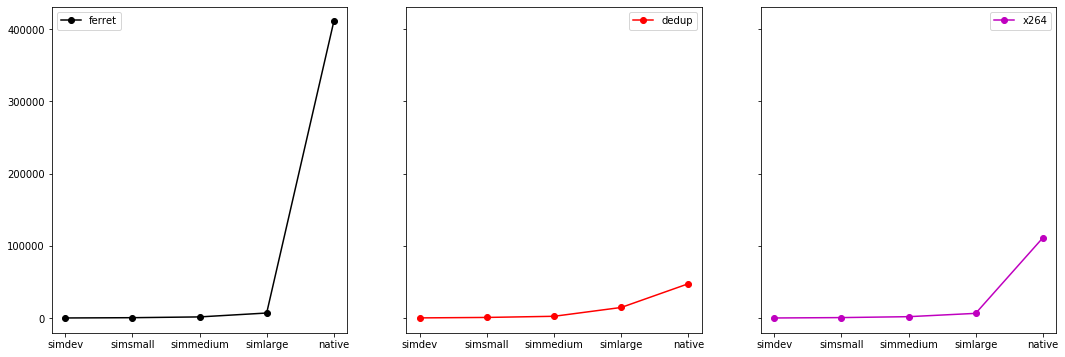

In [9]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)


axs[0].plot(c1data['input'].unique(),(c1data.loc[data['name'] == "ferret"])['real'],'ko-',label='ferret') #no need for str(x_axis)
axs[1].plot(c1data['input'].unique(),(c1data.loc[data['name'] == "dedup"])['real'],'ro-',label='dedup') 
axs[2].plot(c1data['input'].unique(),(c1data.loc[data['name'] == "x264"])['real'],'mo-',label='x264') 
axs[0].legend()
axs[1].legend()
axs[2].legend()

c1data['input'].unique()

#=======================================================================================================================================
#================ Chars for 3 benchmarks : native workload for gcc compiler configuration which is 1 thread and 1 core==================
#=======================================================================================================================================

# Statistical analysis for concurreny supportive compiler configurations

In [10]:
# Filtering parallel data 
parallelData = data.loc[(data['compiler'] != "gcc")]
parallelData = parallelData.drop(['id'],axis=1)

ferretData =parallelData.loc[(parallelData['name'] == "ferret")]
dedupData =parallelData.loc[(parallelData['name'] == "dedup")]
x264Data =parallelData.loc[(parallelData['name'] == "x264")]

# Input combinations in the dataset
inputCombinations = data['input'].unique()
# Thread combinations in the dataset    
threadCombinations = data['threads'].unique()
# cores combinations in the dataset
coresCombinations = data['cores'].unique()

#plots core
plt_coresCombinations = [1,2,4,8,16,32]

In [11]:
#  Drawing the matrix chart
def drawMatrixChartForInputs(x,data,axs,combinations,multiline,title,xlabel,ylabel,column='threads'):
    j=0
    for inputCombination in inputCombinations:
        y = data.loc[(data['input'] == inputCombination) ]
        y.head()
        minimum = min(y['real'])
        maximum = max(y['real'])
        i = 0
        for combination in combinations:
            axs[j][i].plot(x,(y.loc[y['threads'] == combination])['real'],label=(str(combination)+"-"+multiline),marker="o")
            axs[j][i].legend(loc=2)
            axs[j][i].set_xlabel('cores', fontsize=12)
            axs[j][i].set_ylabel('execution time', fontsize=12)
            axs[j][i].set_title(inputCombination, fontsize=14)
            axs[j][i].set_ylim(bottom=minimum,top=maximum)
            annot_max(x,(y.loc[y['threads'] == combination])['real'],axs[j,i])
            i = i +1
        j = j +1
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)

#Drawing a single Chart
def drawChartForInputs(x,y,axs,combinations,multiline,title,xlabel,ylabel,column='threads'):
    plt.rcParams["figure.figsize"] = (20,20)
    for combination in combinations:
        plt.plot(x,(y.loc[y[column] == combination])['real'],label=(str(combination)+"-"+multiline),marker="o")
      

    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.title(title,fontsize=16)
    annot_max(x,(y.loc[y['threads'] == combination])['real'],plt)
    plt.legend(loc=2)

def annot_max(x,y, ax=None):
    xmin = data.iloc[y.idxmin].cores
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)


## Analysis with threads and execution time for different number of cores

### Ferret Analysis

In [12]:
# phtread version
ferretPThreadData =ferretData.loc[ferretData['compiler'] == "gcc-pthreads"]

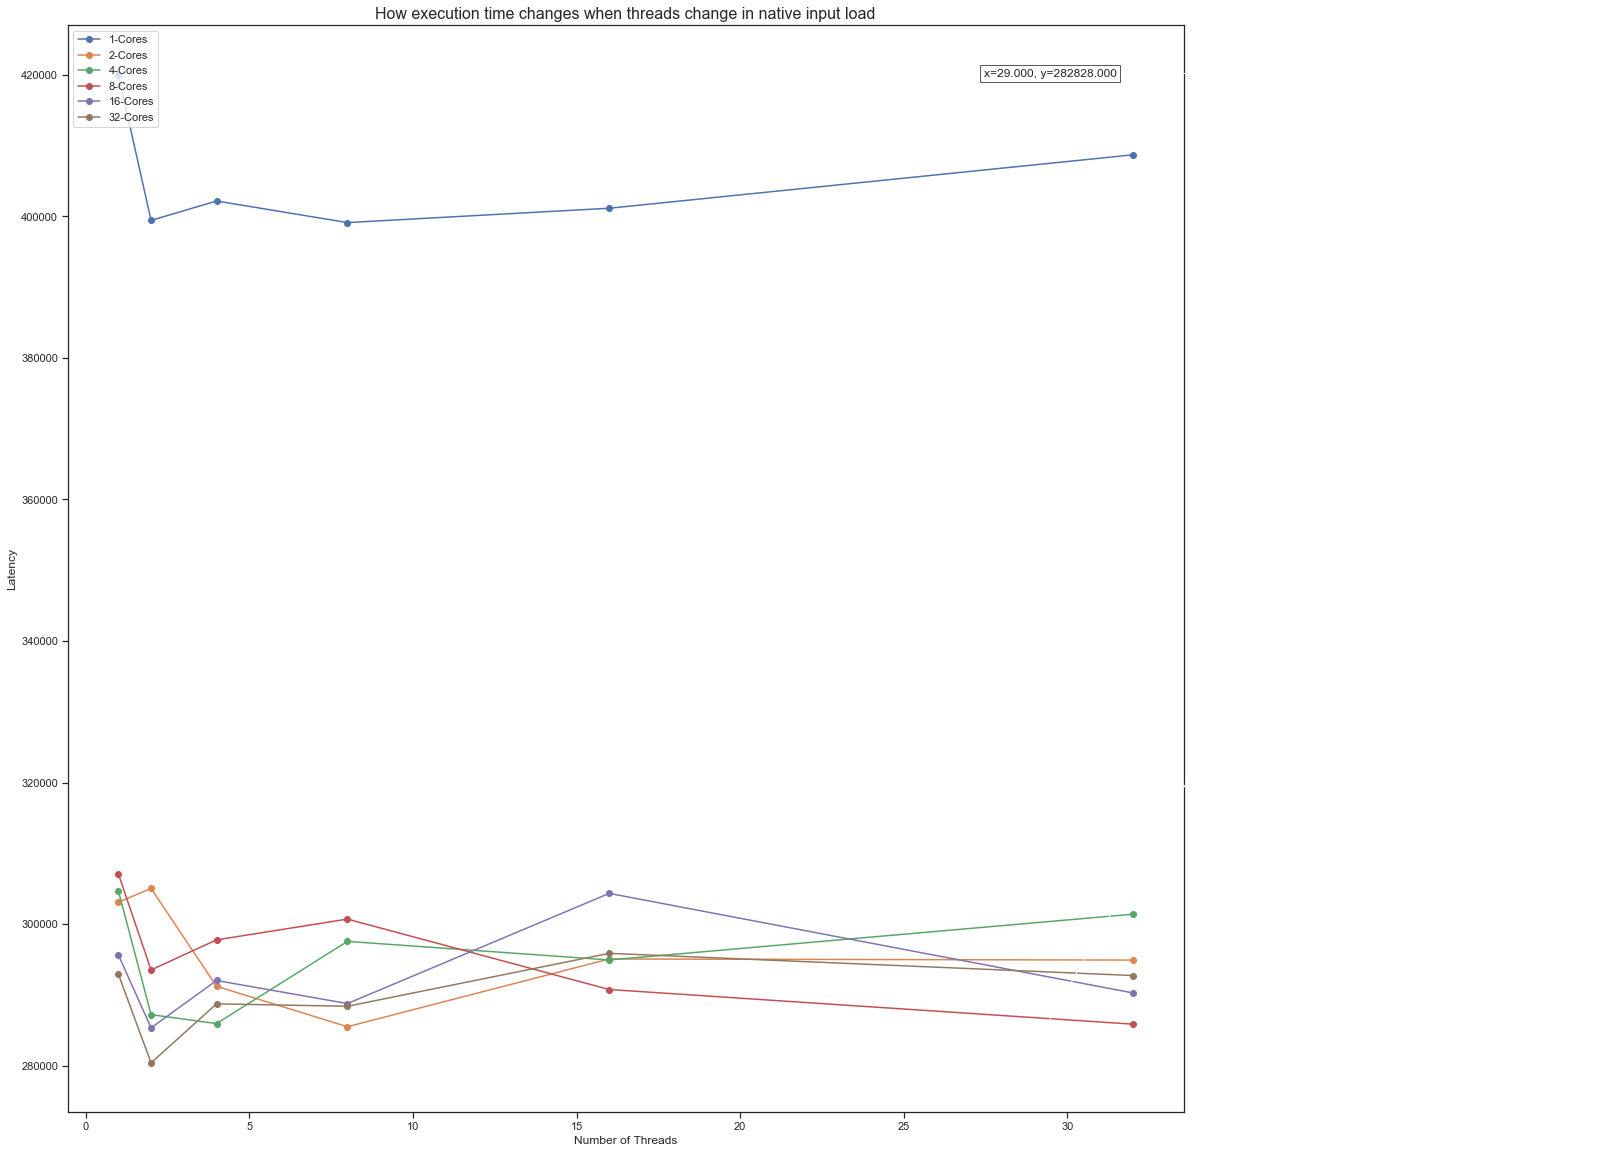

In [72]:
# Filtering for simdev
inputCombinationData = ferretPThreadData.loc[(ferretPThreadData['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

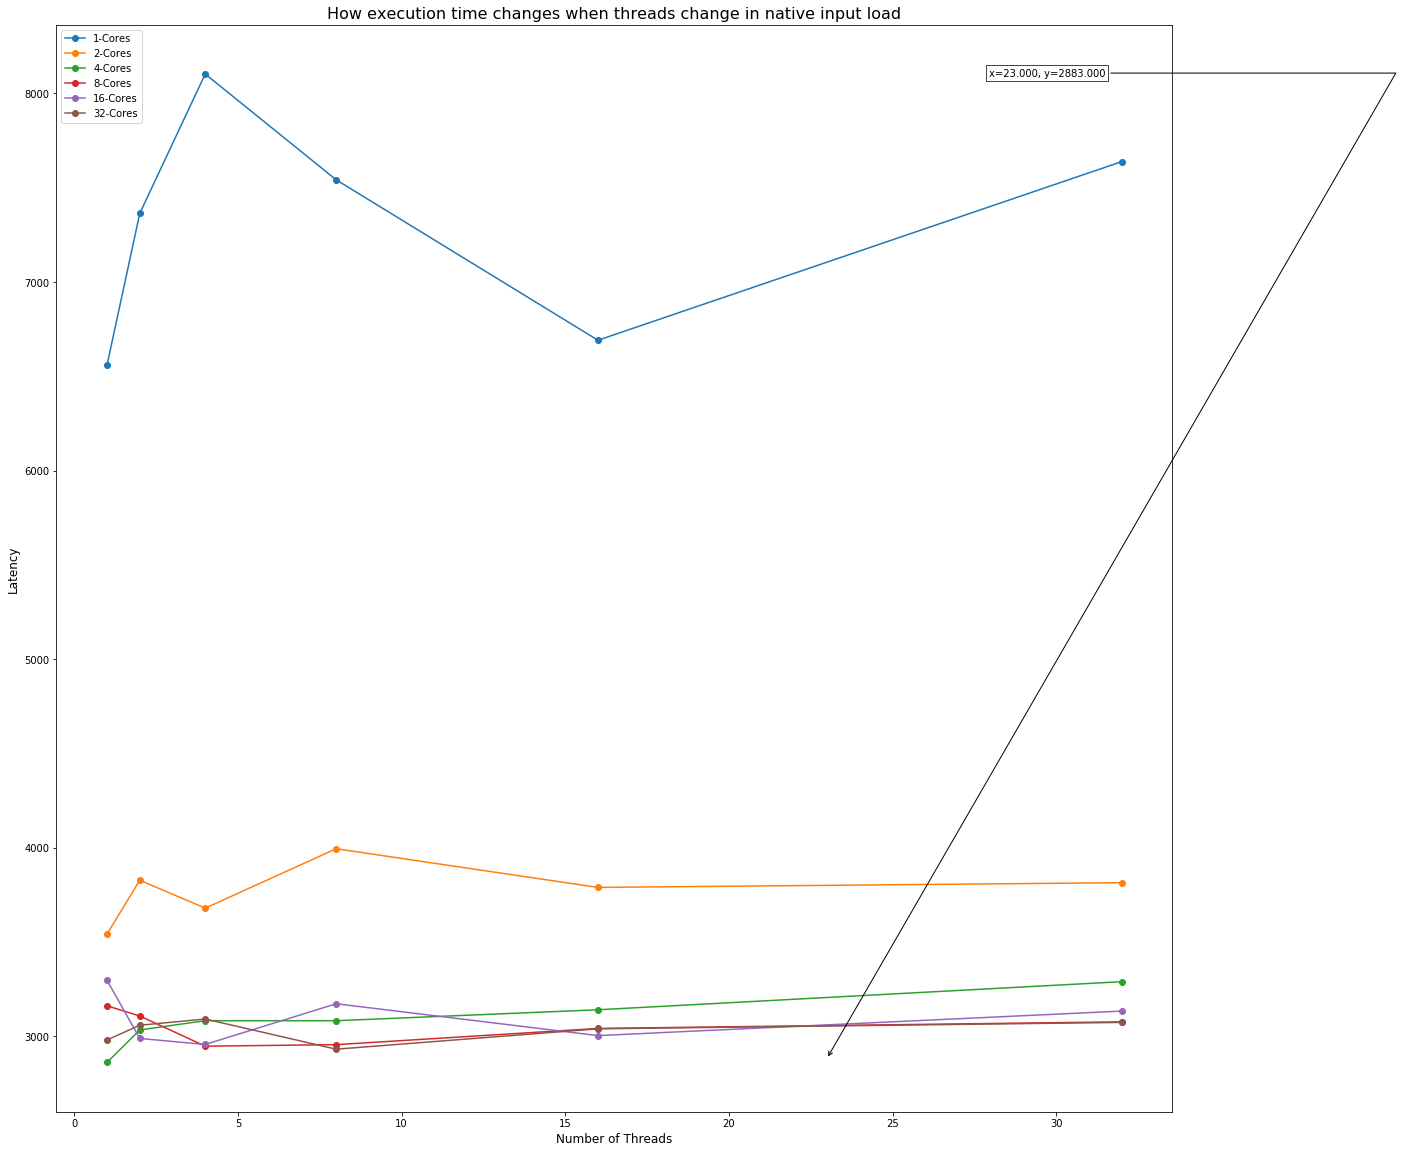

In [14]:
# Filtering for simdev
inputCombinationData = ferretPThreadData.loc[(ferretPThreadData['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

In [15]:
# gcc-tbb compiler configuration
ferretTBBData =ferretData.loc[ferretData['compiler'] == "gcc-tbb"]

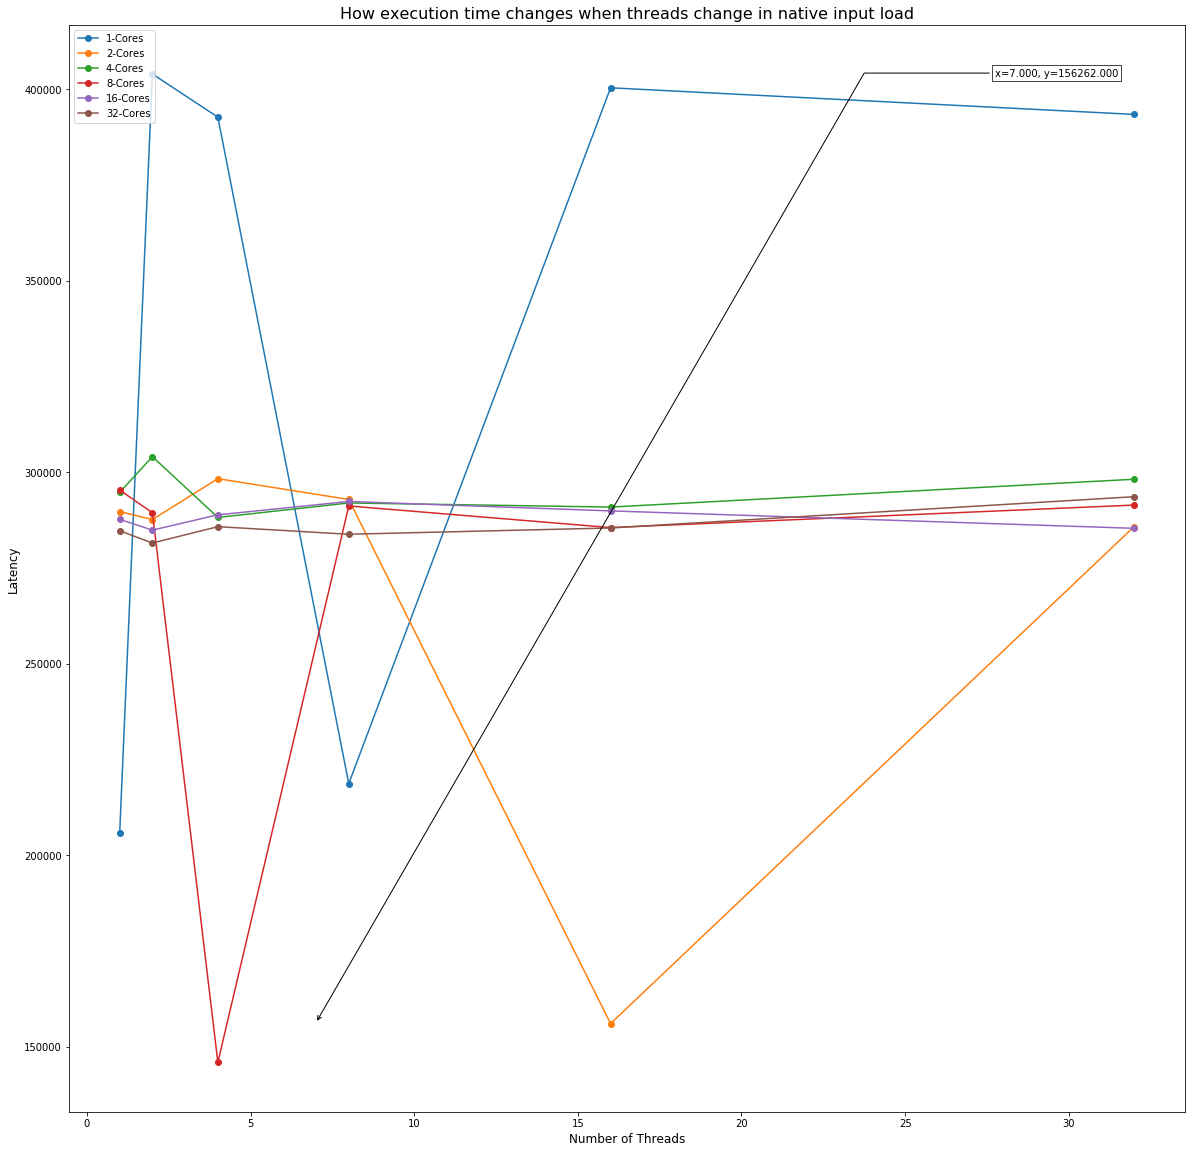

In [16]:
# Filtering for simdev
inputCombinationData = ferretTBBData.loc[(ferretTBBData['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

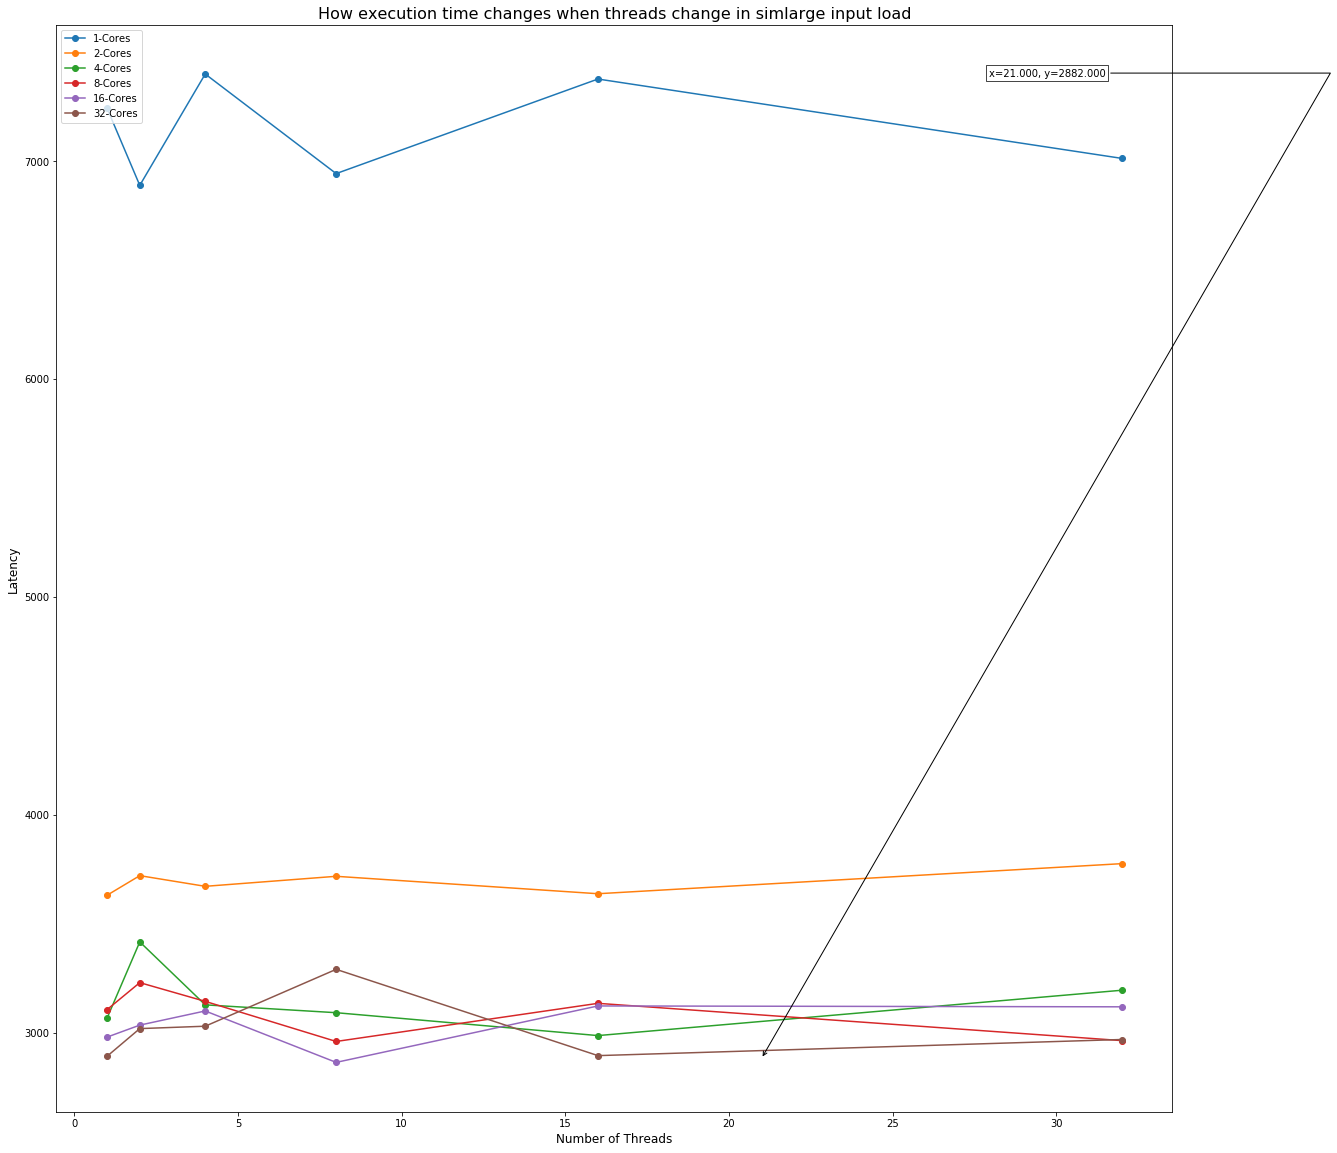

In [17]:
# Filtering for simdev
inputCombinationData = ferretTBBData.loc[(ferretTBBData['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in simlarge input load",'Number of Threads',"Latency",'cores')

### Dedup Analysis

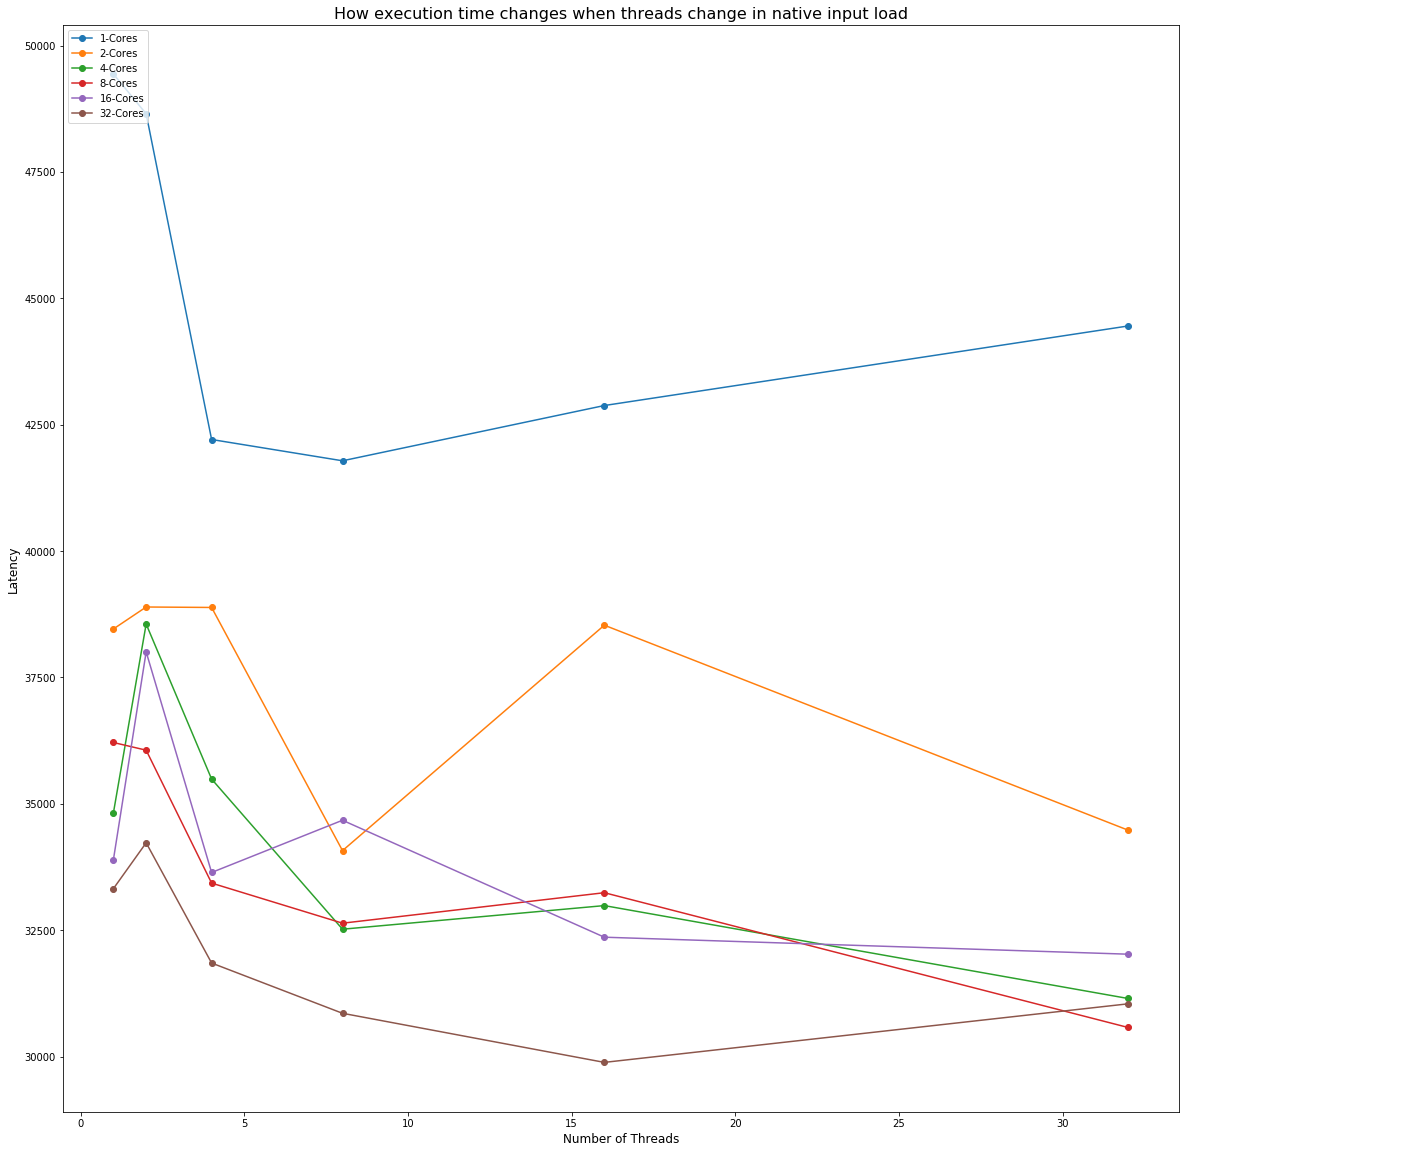

In [18]:
# Filtering for native
inputCombinationData = dedupData.loc[(dedupData['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

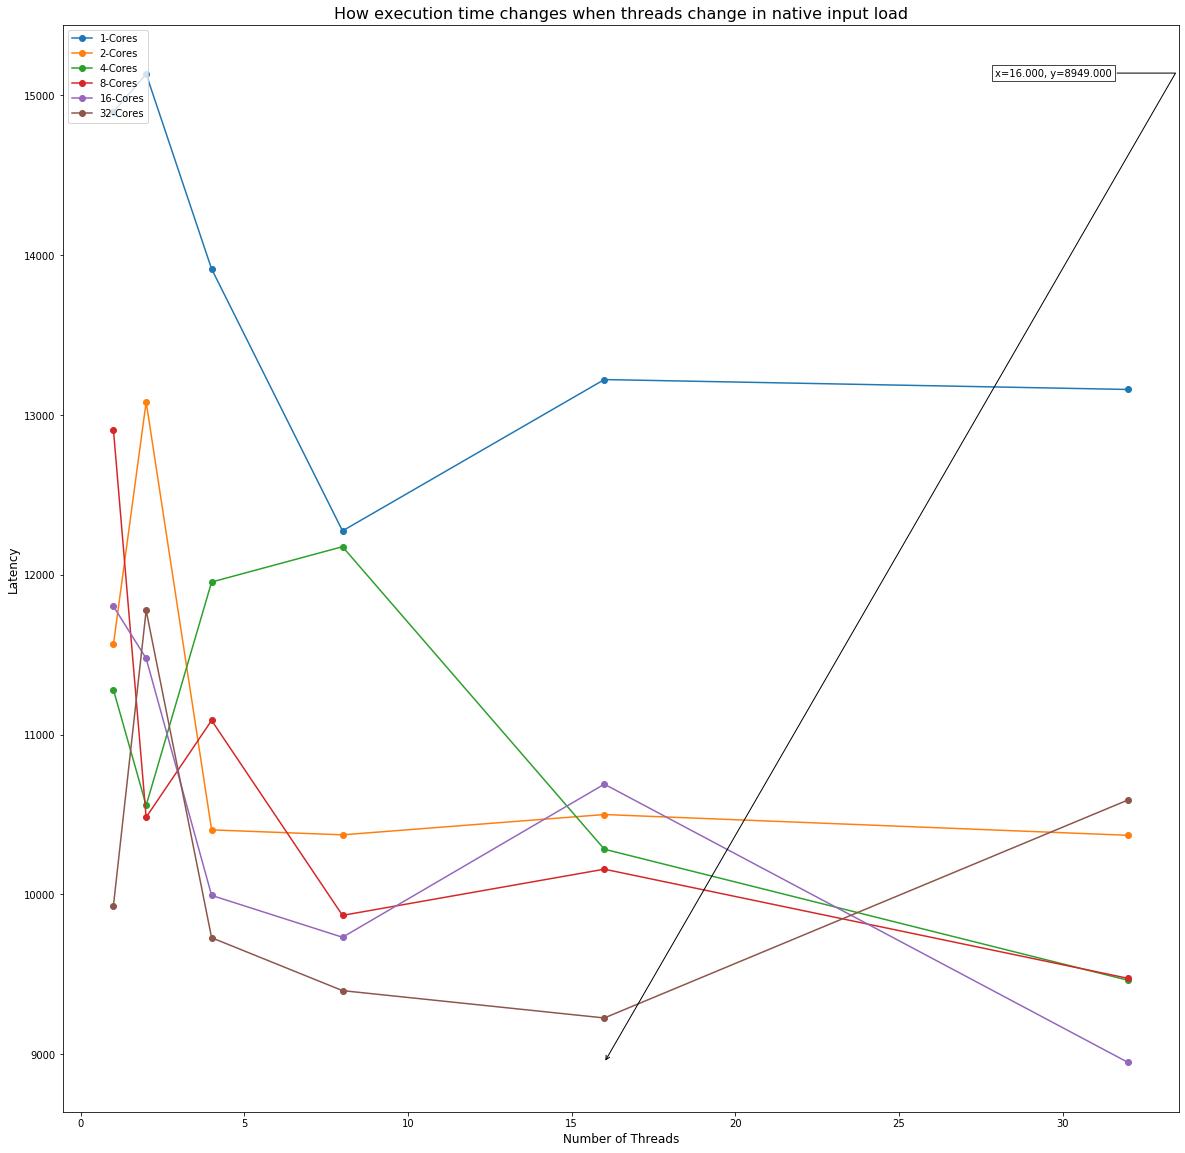

In [19]:
# Filtering for native
inputCombinationData = dedupData.loc[(dedupData['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

### x264 Analysis

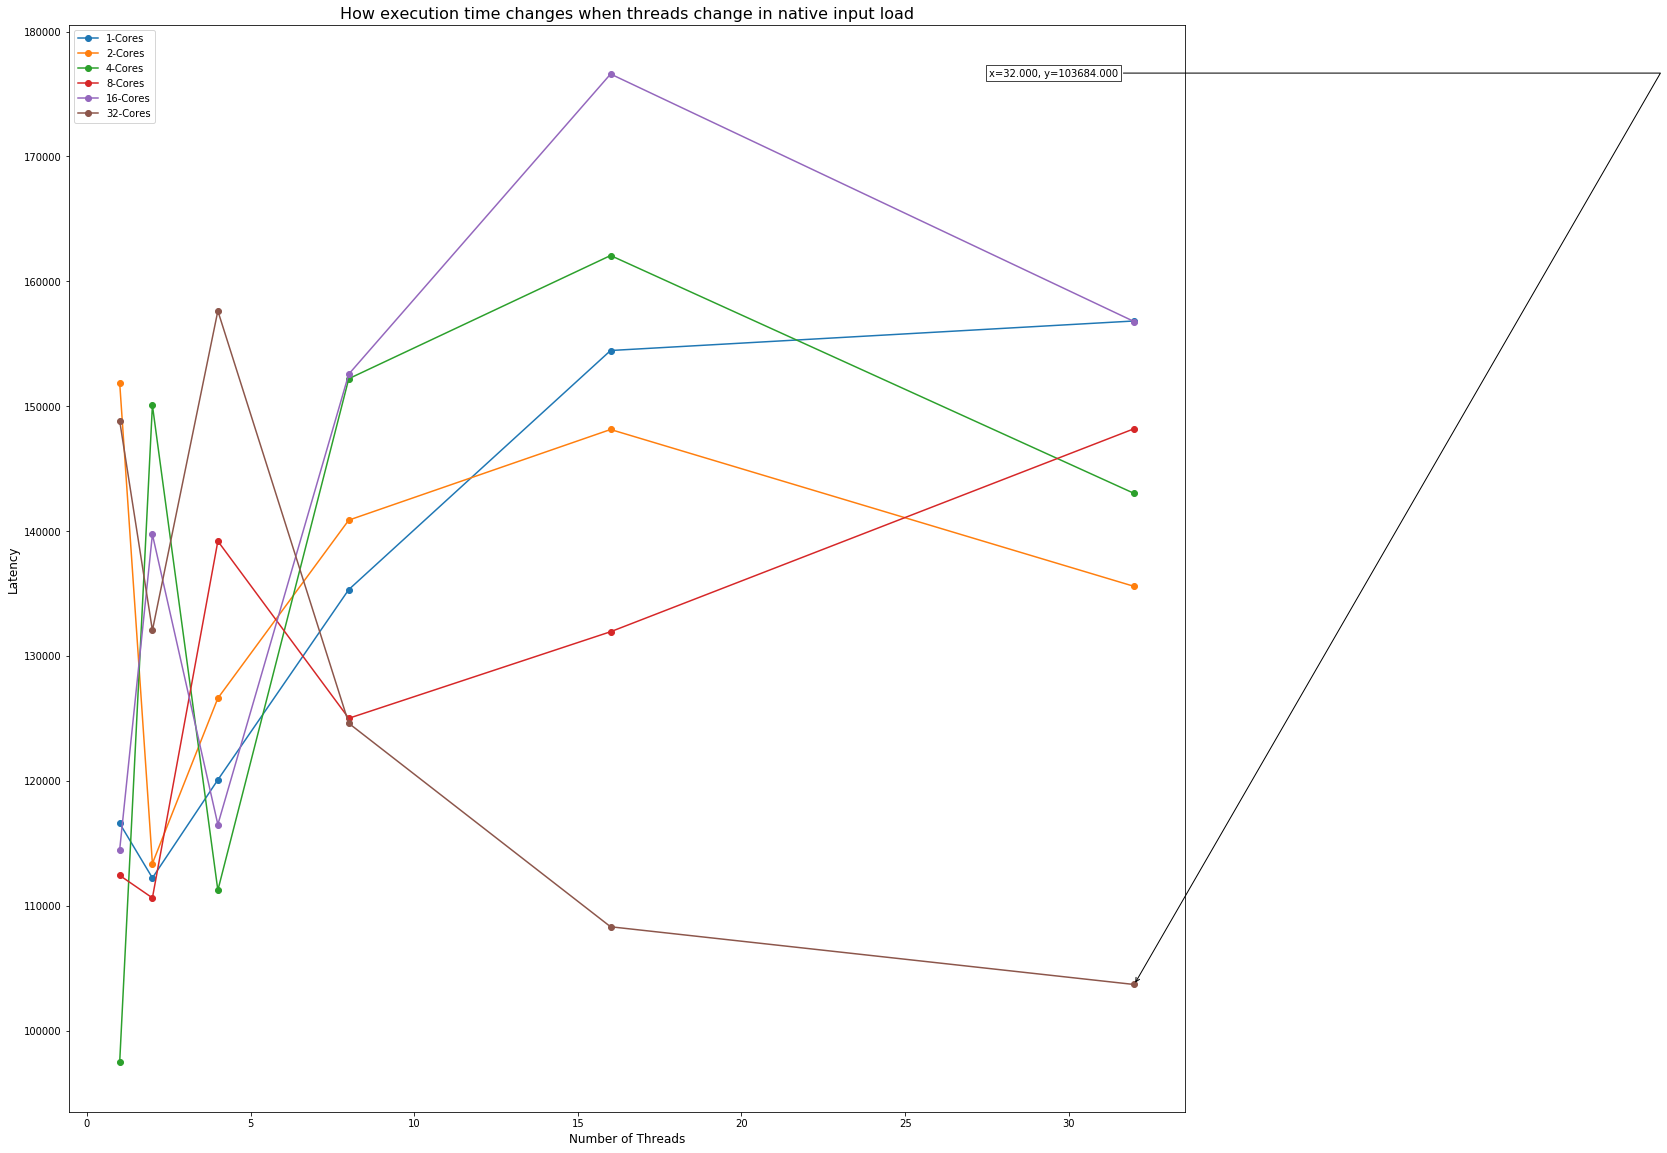

In [20]:
# Filtering for native
inputCombinationData = x264Data.loc[(x264Data['input'] == "native") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in native input load",'Number of Threads',"Latency",'cores')

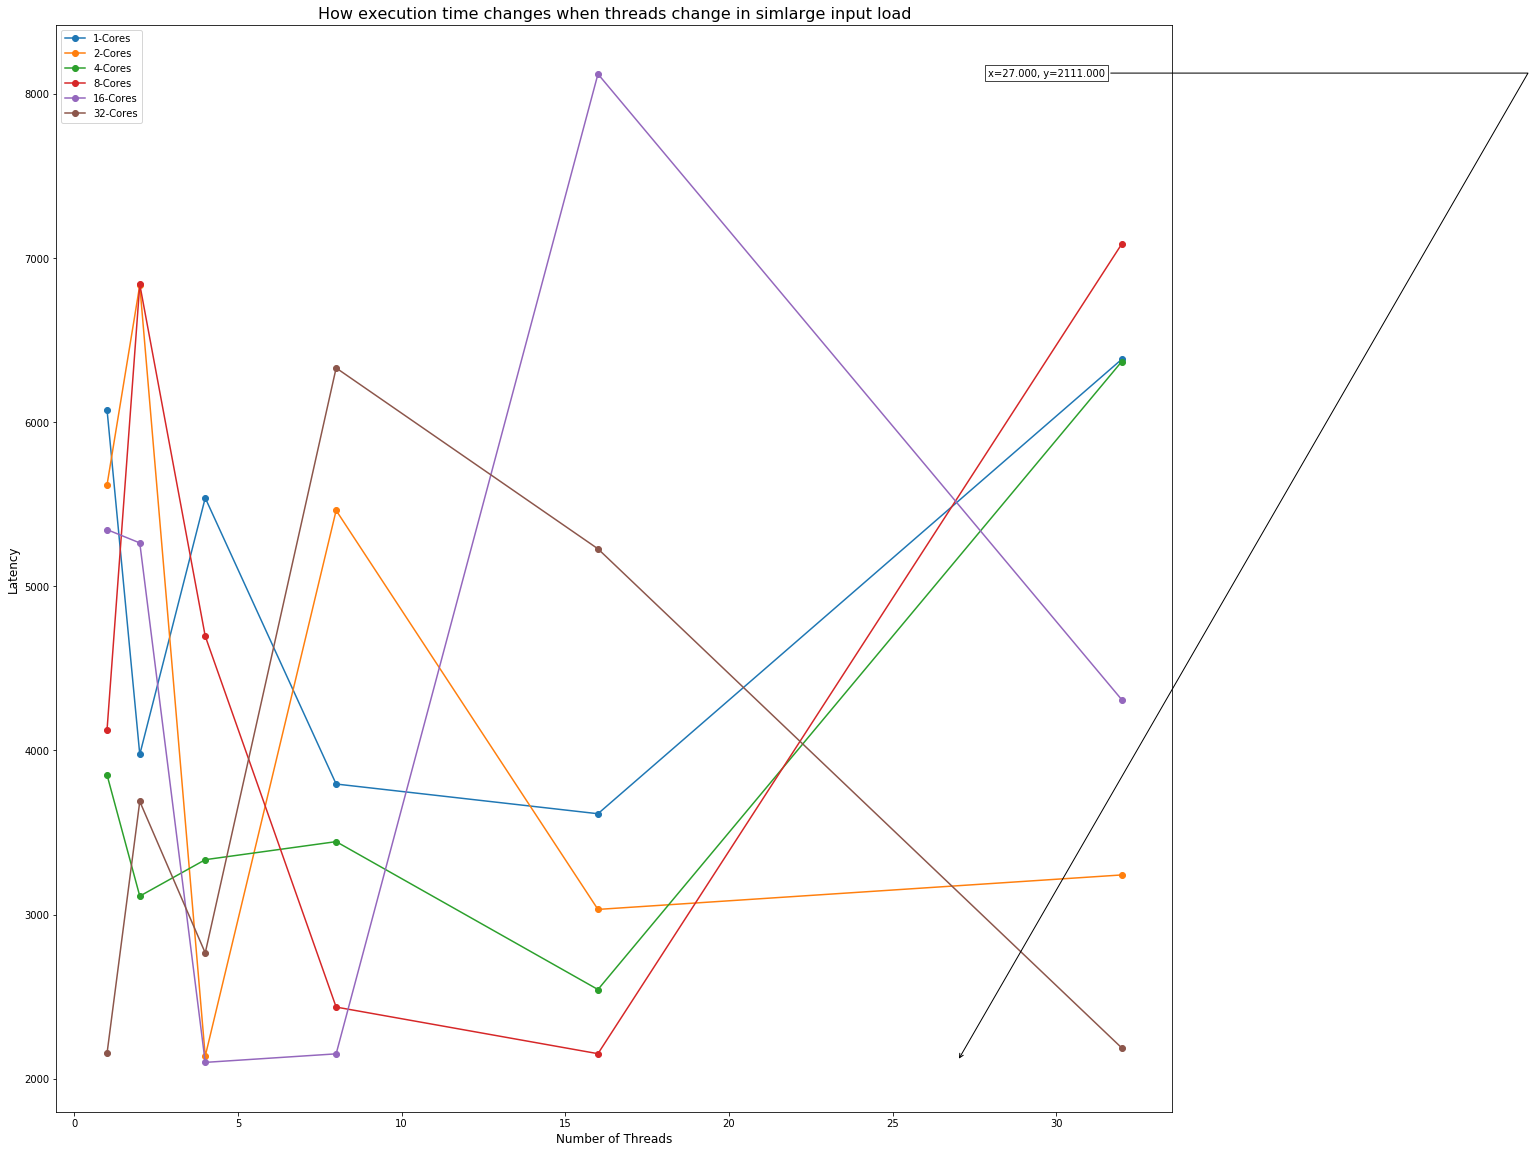

In [21]:
# Filtering for native
inputCombinationData = x264Data.loc[(x264Data['input'] == "simlarge") ]
drawChartForInputs(threadCombinations,inputCombinationData,axs,plt_coresCombinations,'Cores',"How execution time changes when threads change in simlarge input load",'Number of Threads',"Latency",'cores')

## Analysis with cores and execution time for different number of threads

### Ferret Analysis

In [22]:
# phtread version
ferretPThreadData =ferretData.loc[ferretData['compiler'] == "gcc-pthreads"]


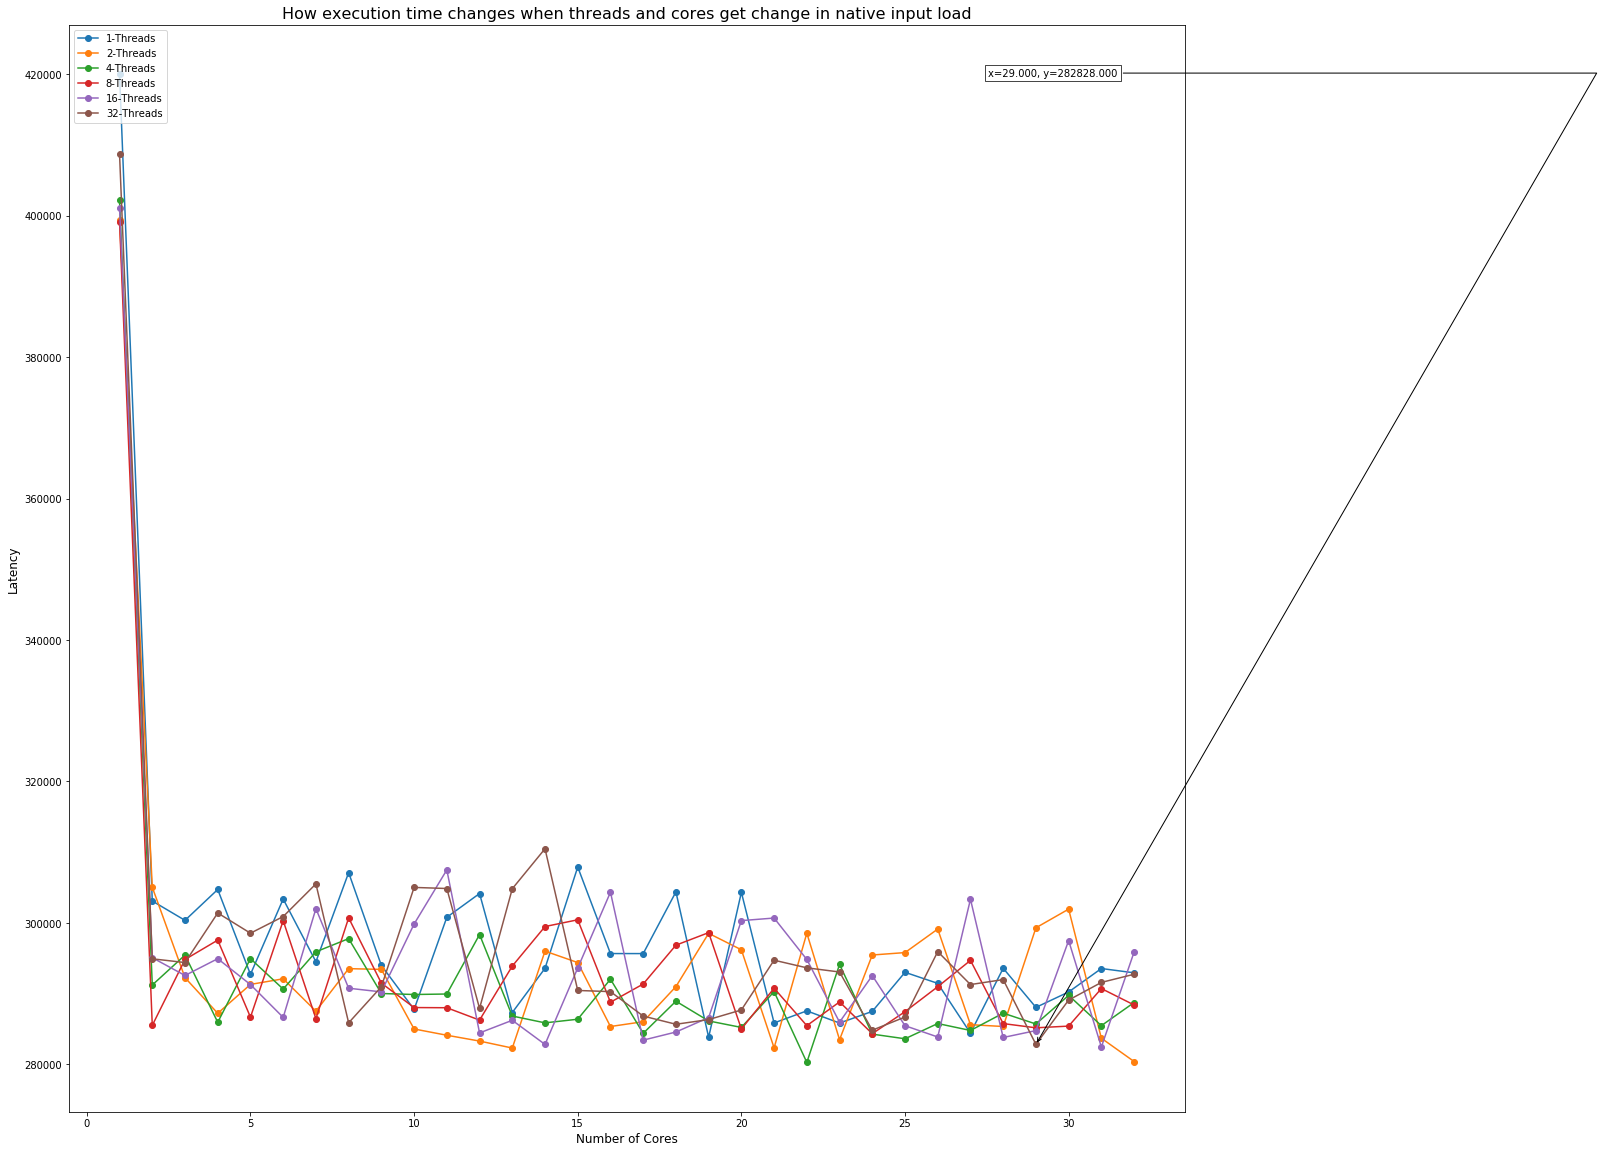

In [23]:
# Filtering for simdev
inputCombinationData = ferretPThreadData.loc[(ferretPThreadData['input'] == "native") ]
drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in native input load",'Number of Cores',"Latency")

<Figure size 1440x1440 with 0 Axes>

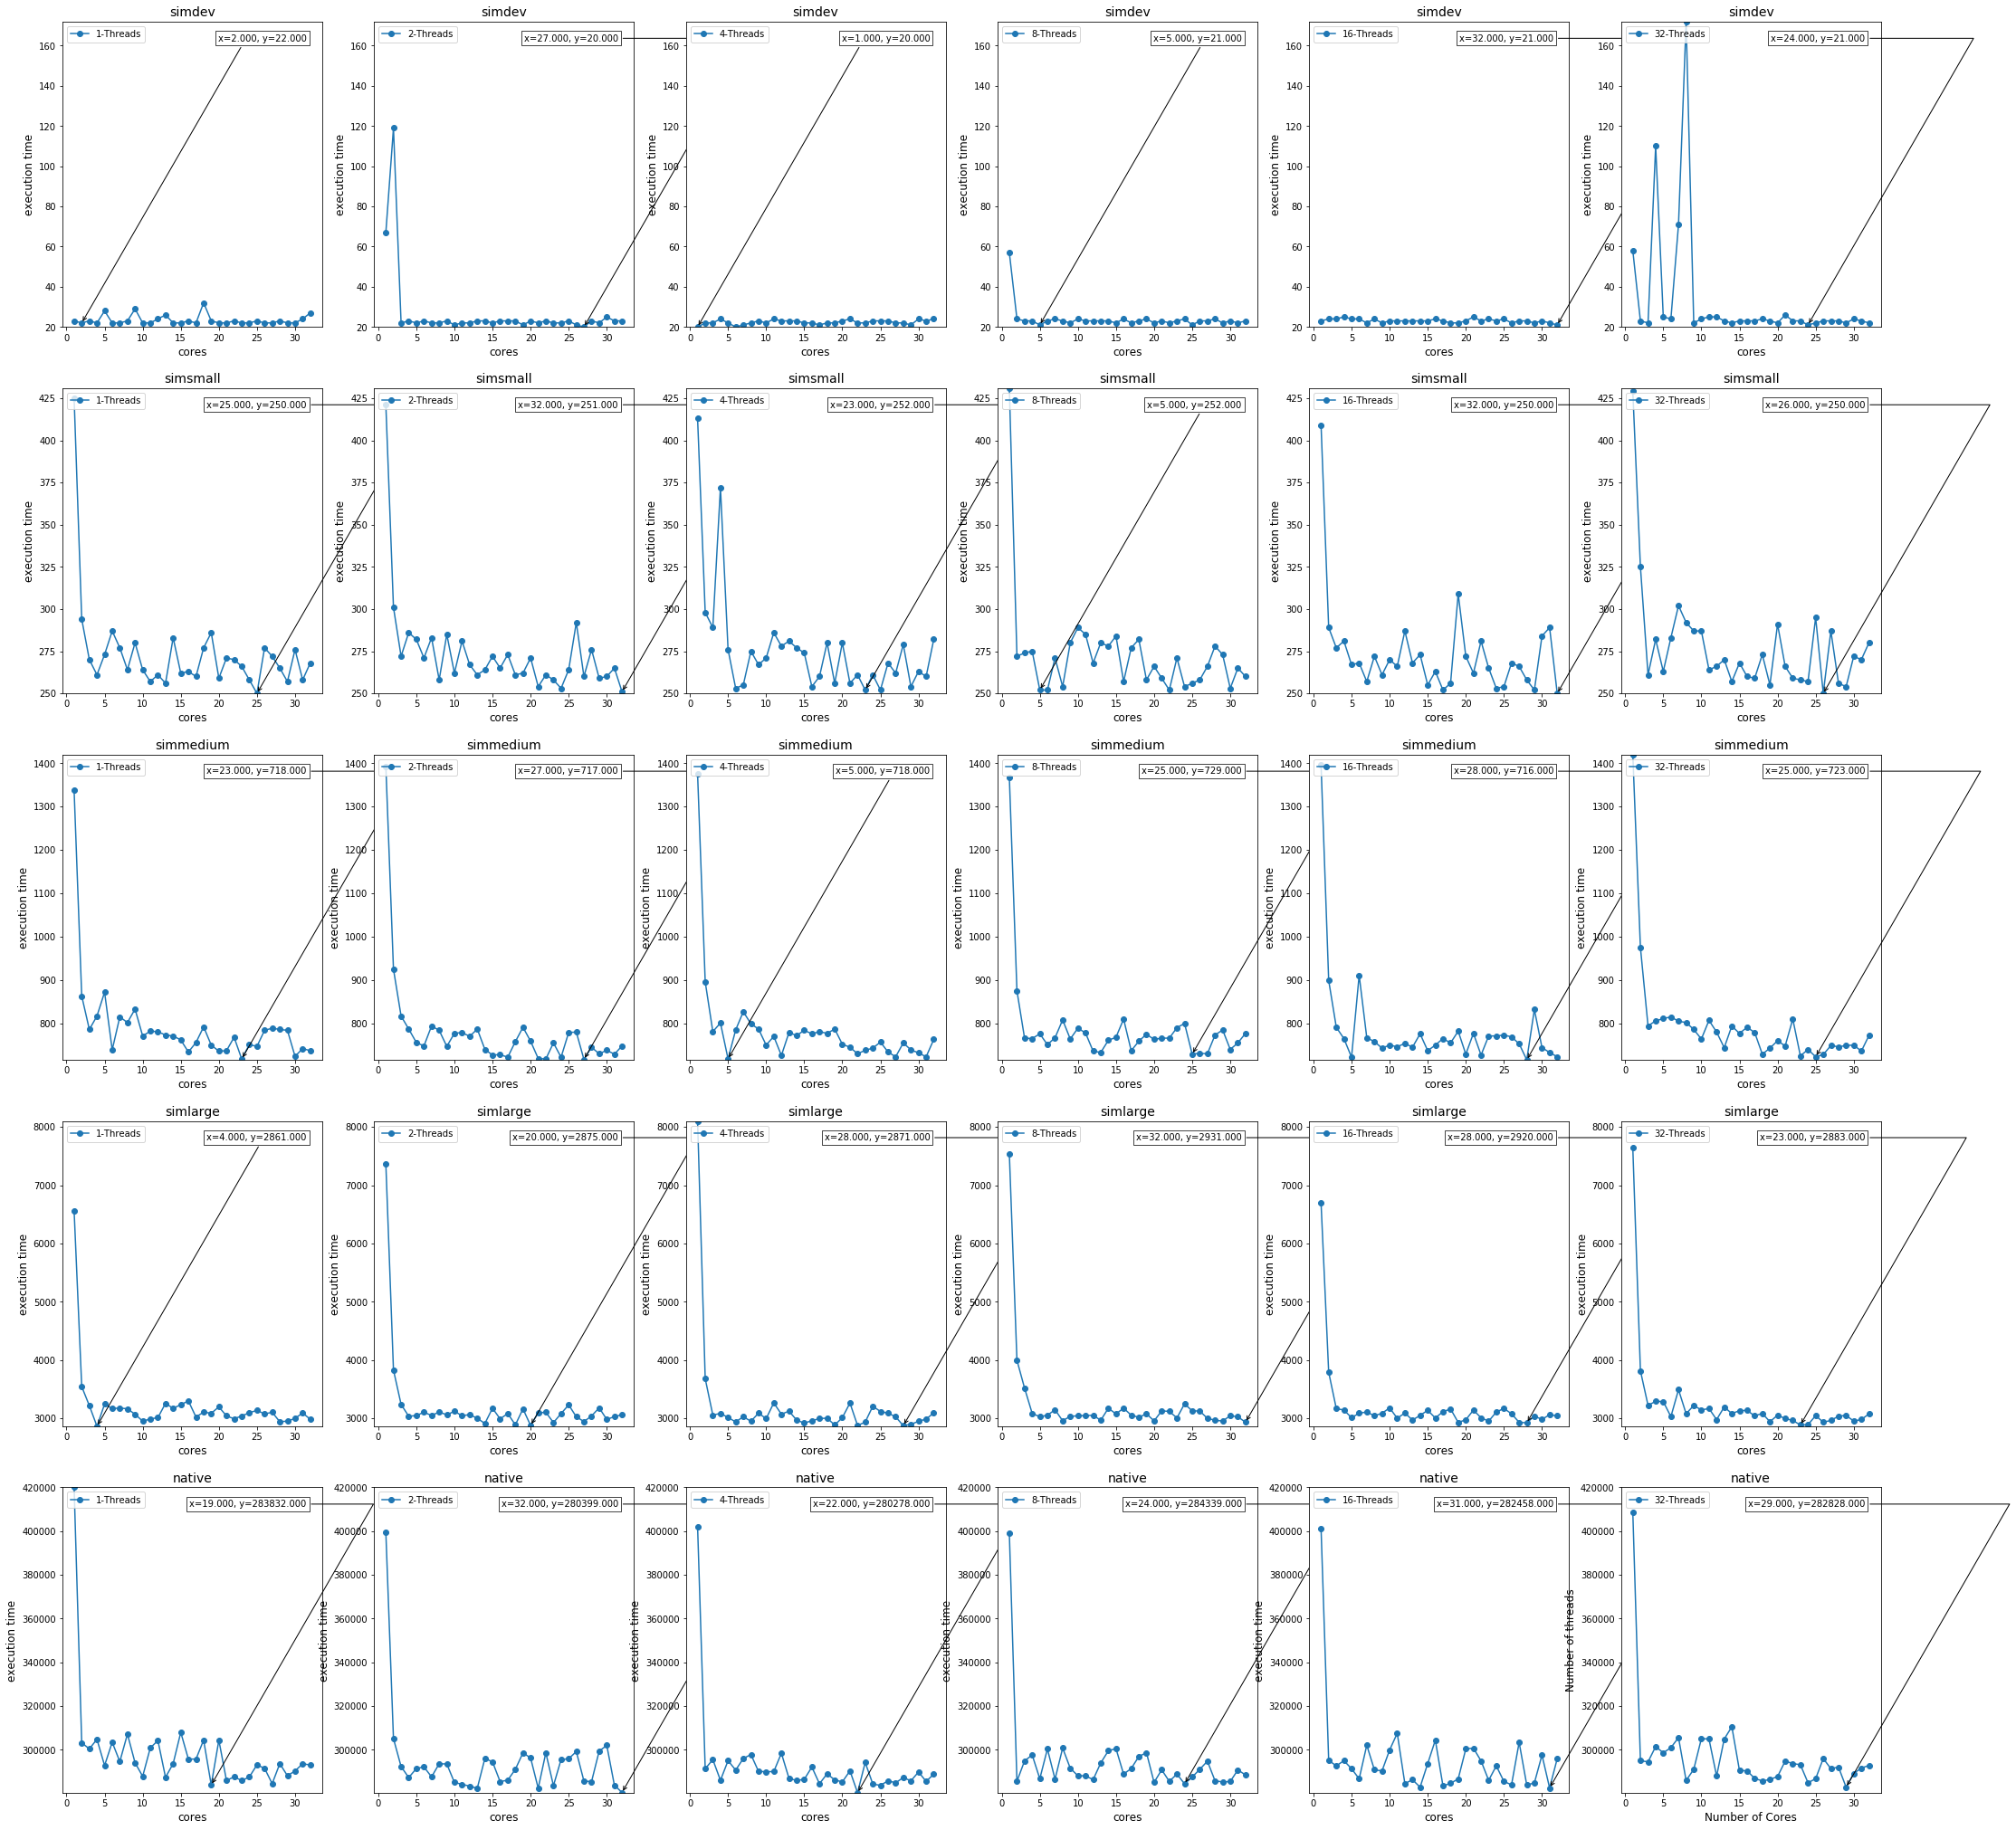

In [24]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,ferretPThreadData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

In [25]:
# gcc-tbb compiler configuration
ferretTBBData =ferretData.loc[ferretData['compiler'] == "gcc-tbb"]

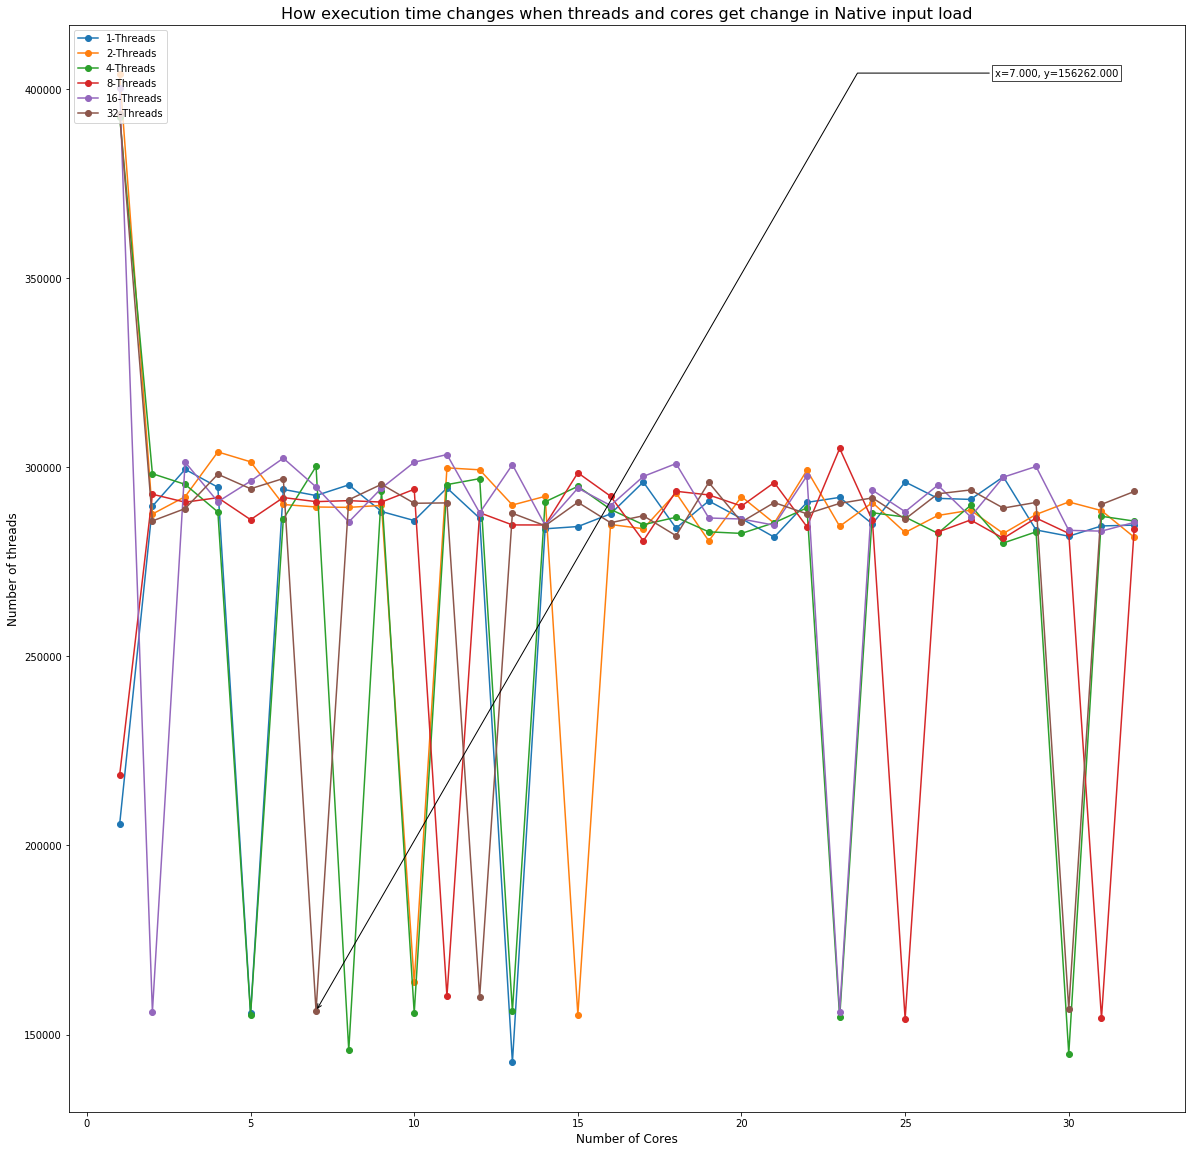

In [26]:
# Filtering for simdev
inputCombinationData = ferretTBBData.loc[(ferretTBBData['input'] == "native") ]

drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in Native input load",'Number of Cores',"Number of threads")

<Figure size 1440x1440 with 0 Axes>

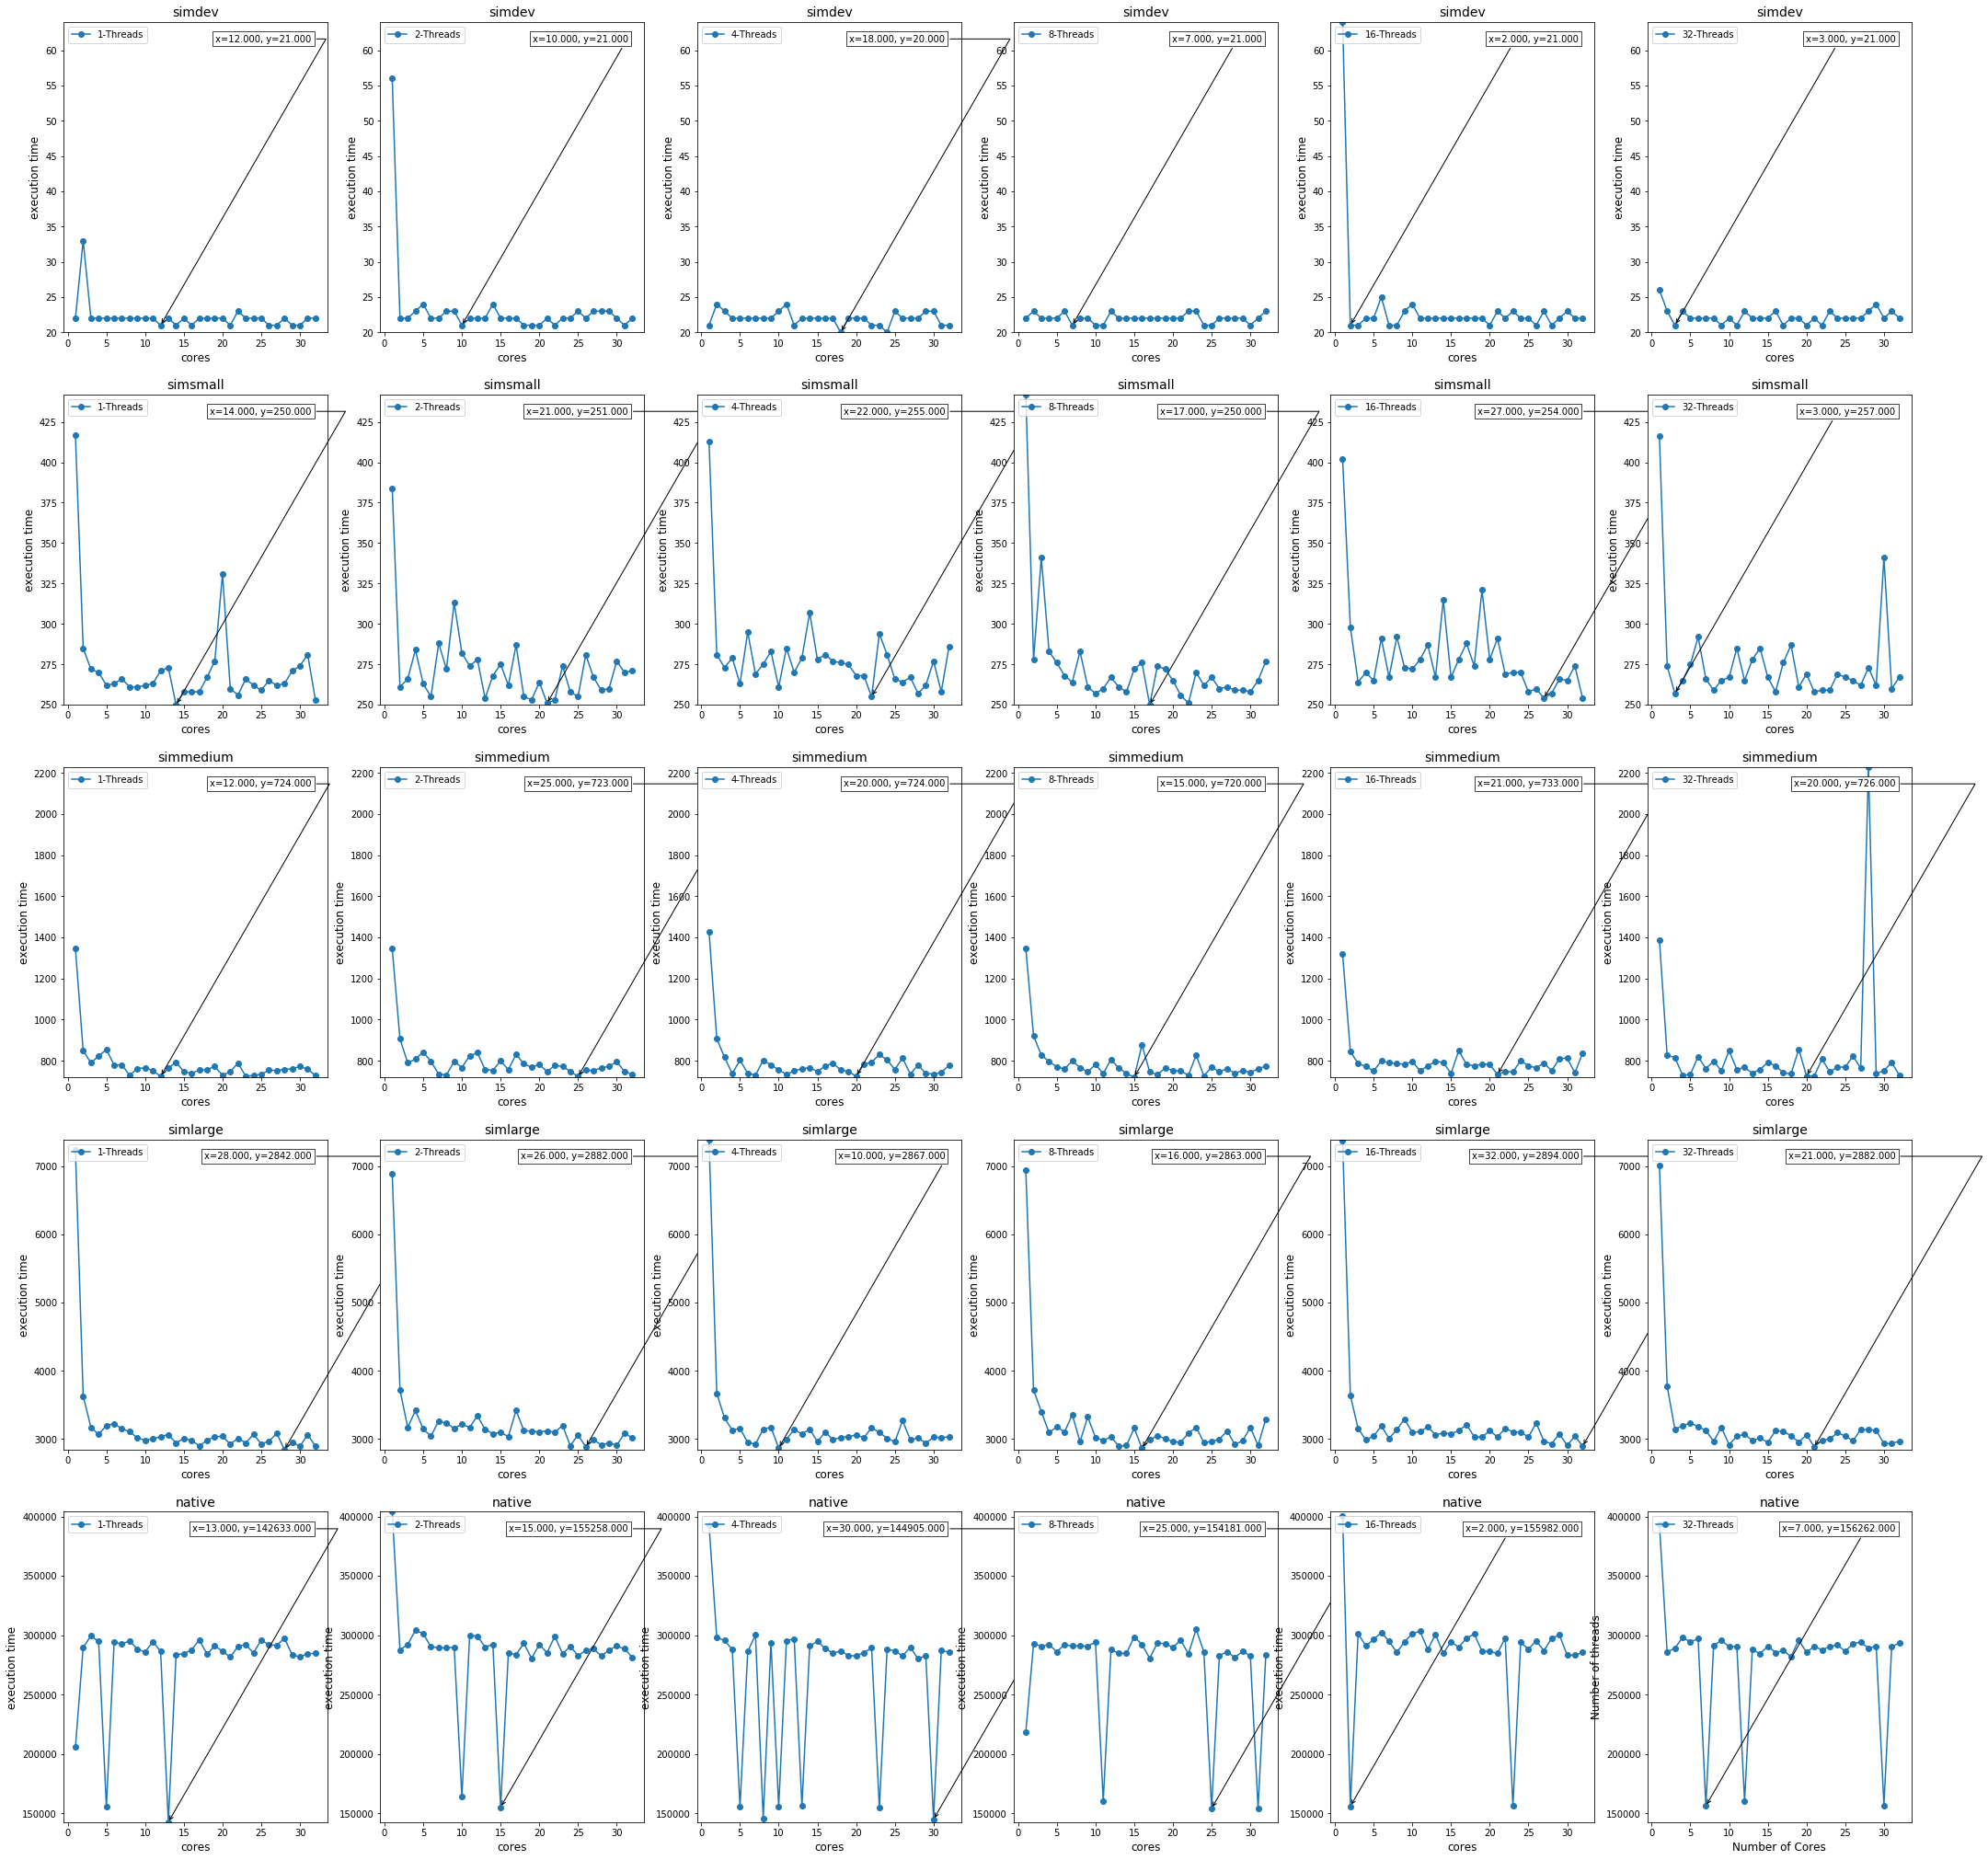

In [27]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,ferretTBBData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

# Dedup Analysis

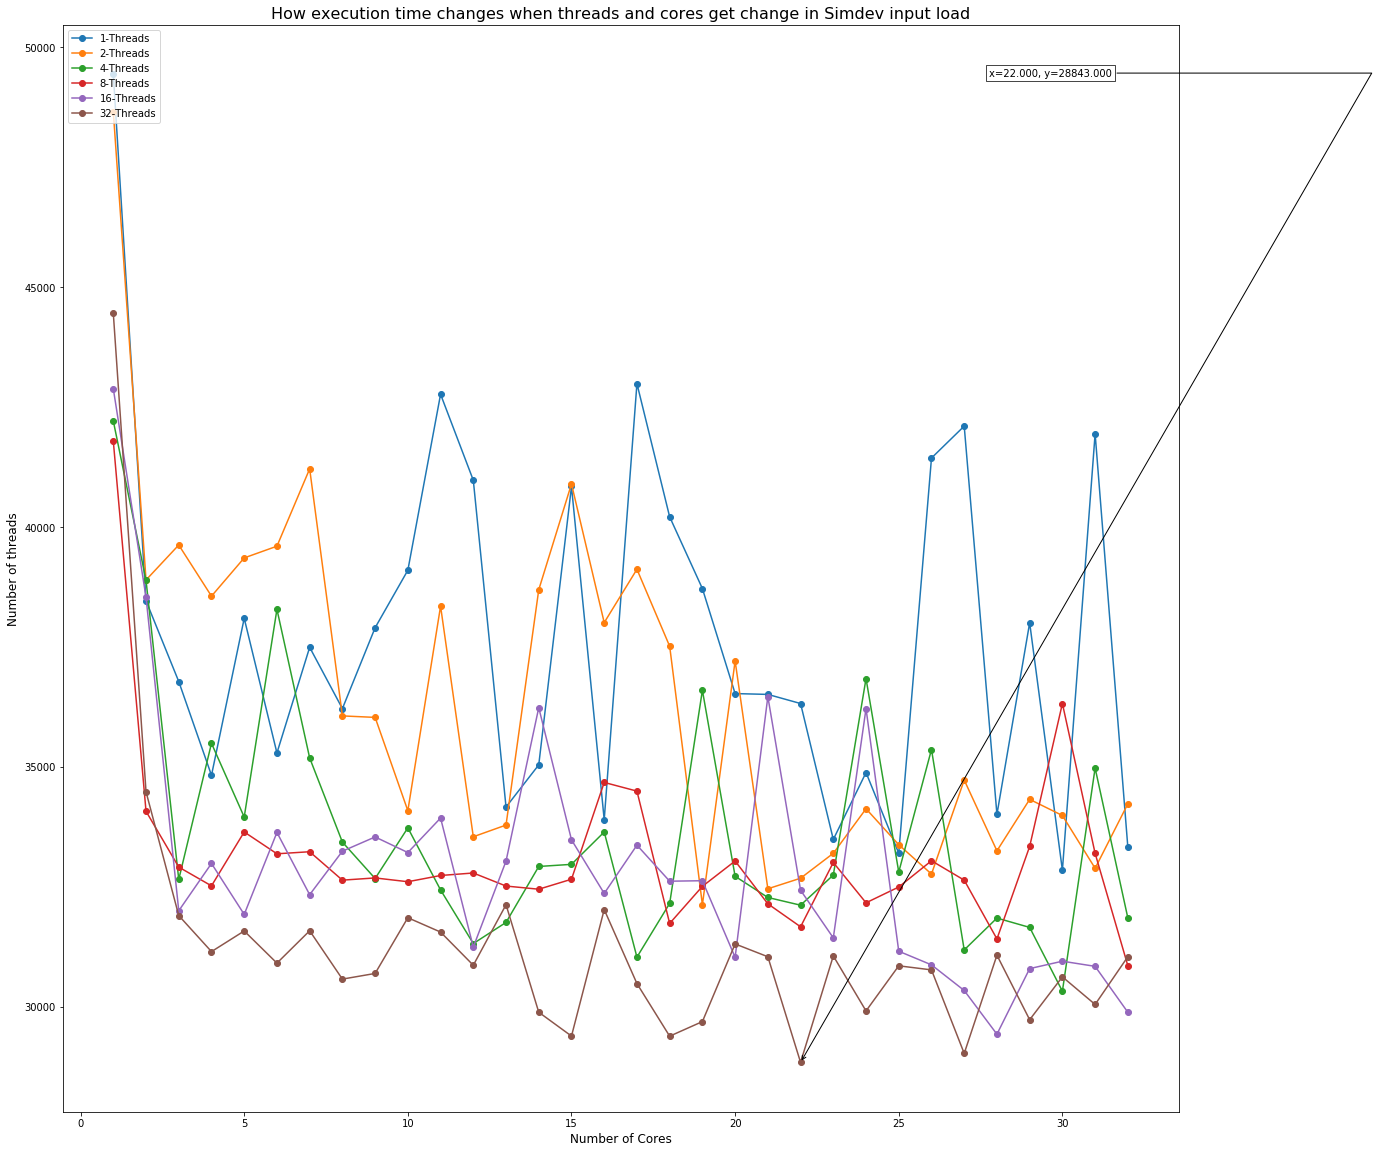

In [28]:
# Filtering for native
inputCombinationData = dedupData.loc[(dedupData['input'] == "native") ]
drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in Simdev input load",'Number of Cores',"Number of threads")

<Figure size 1440x1440 with 0 Axes>

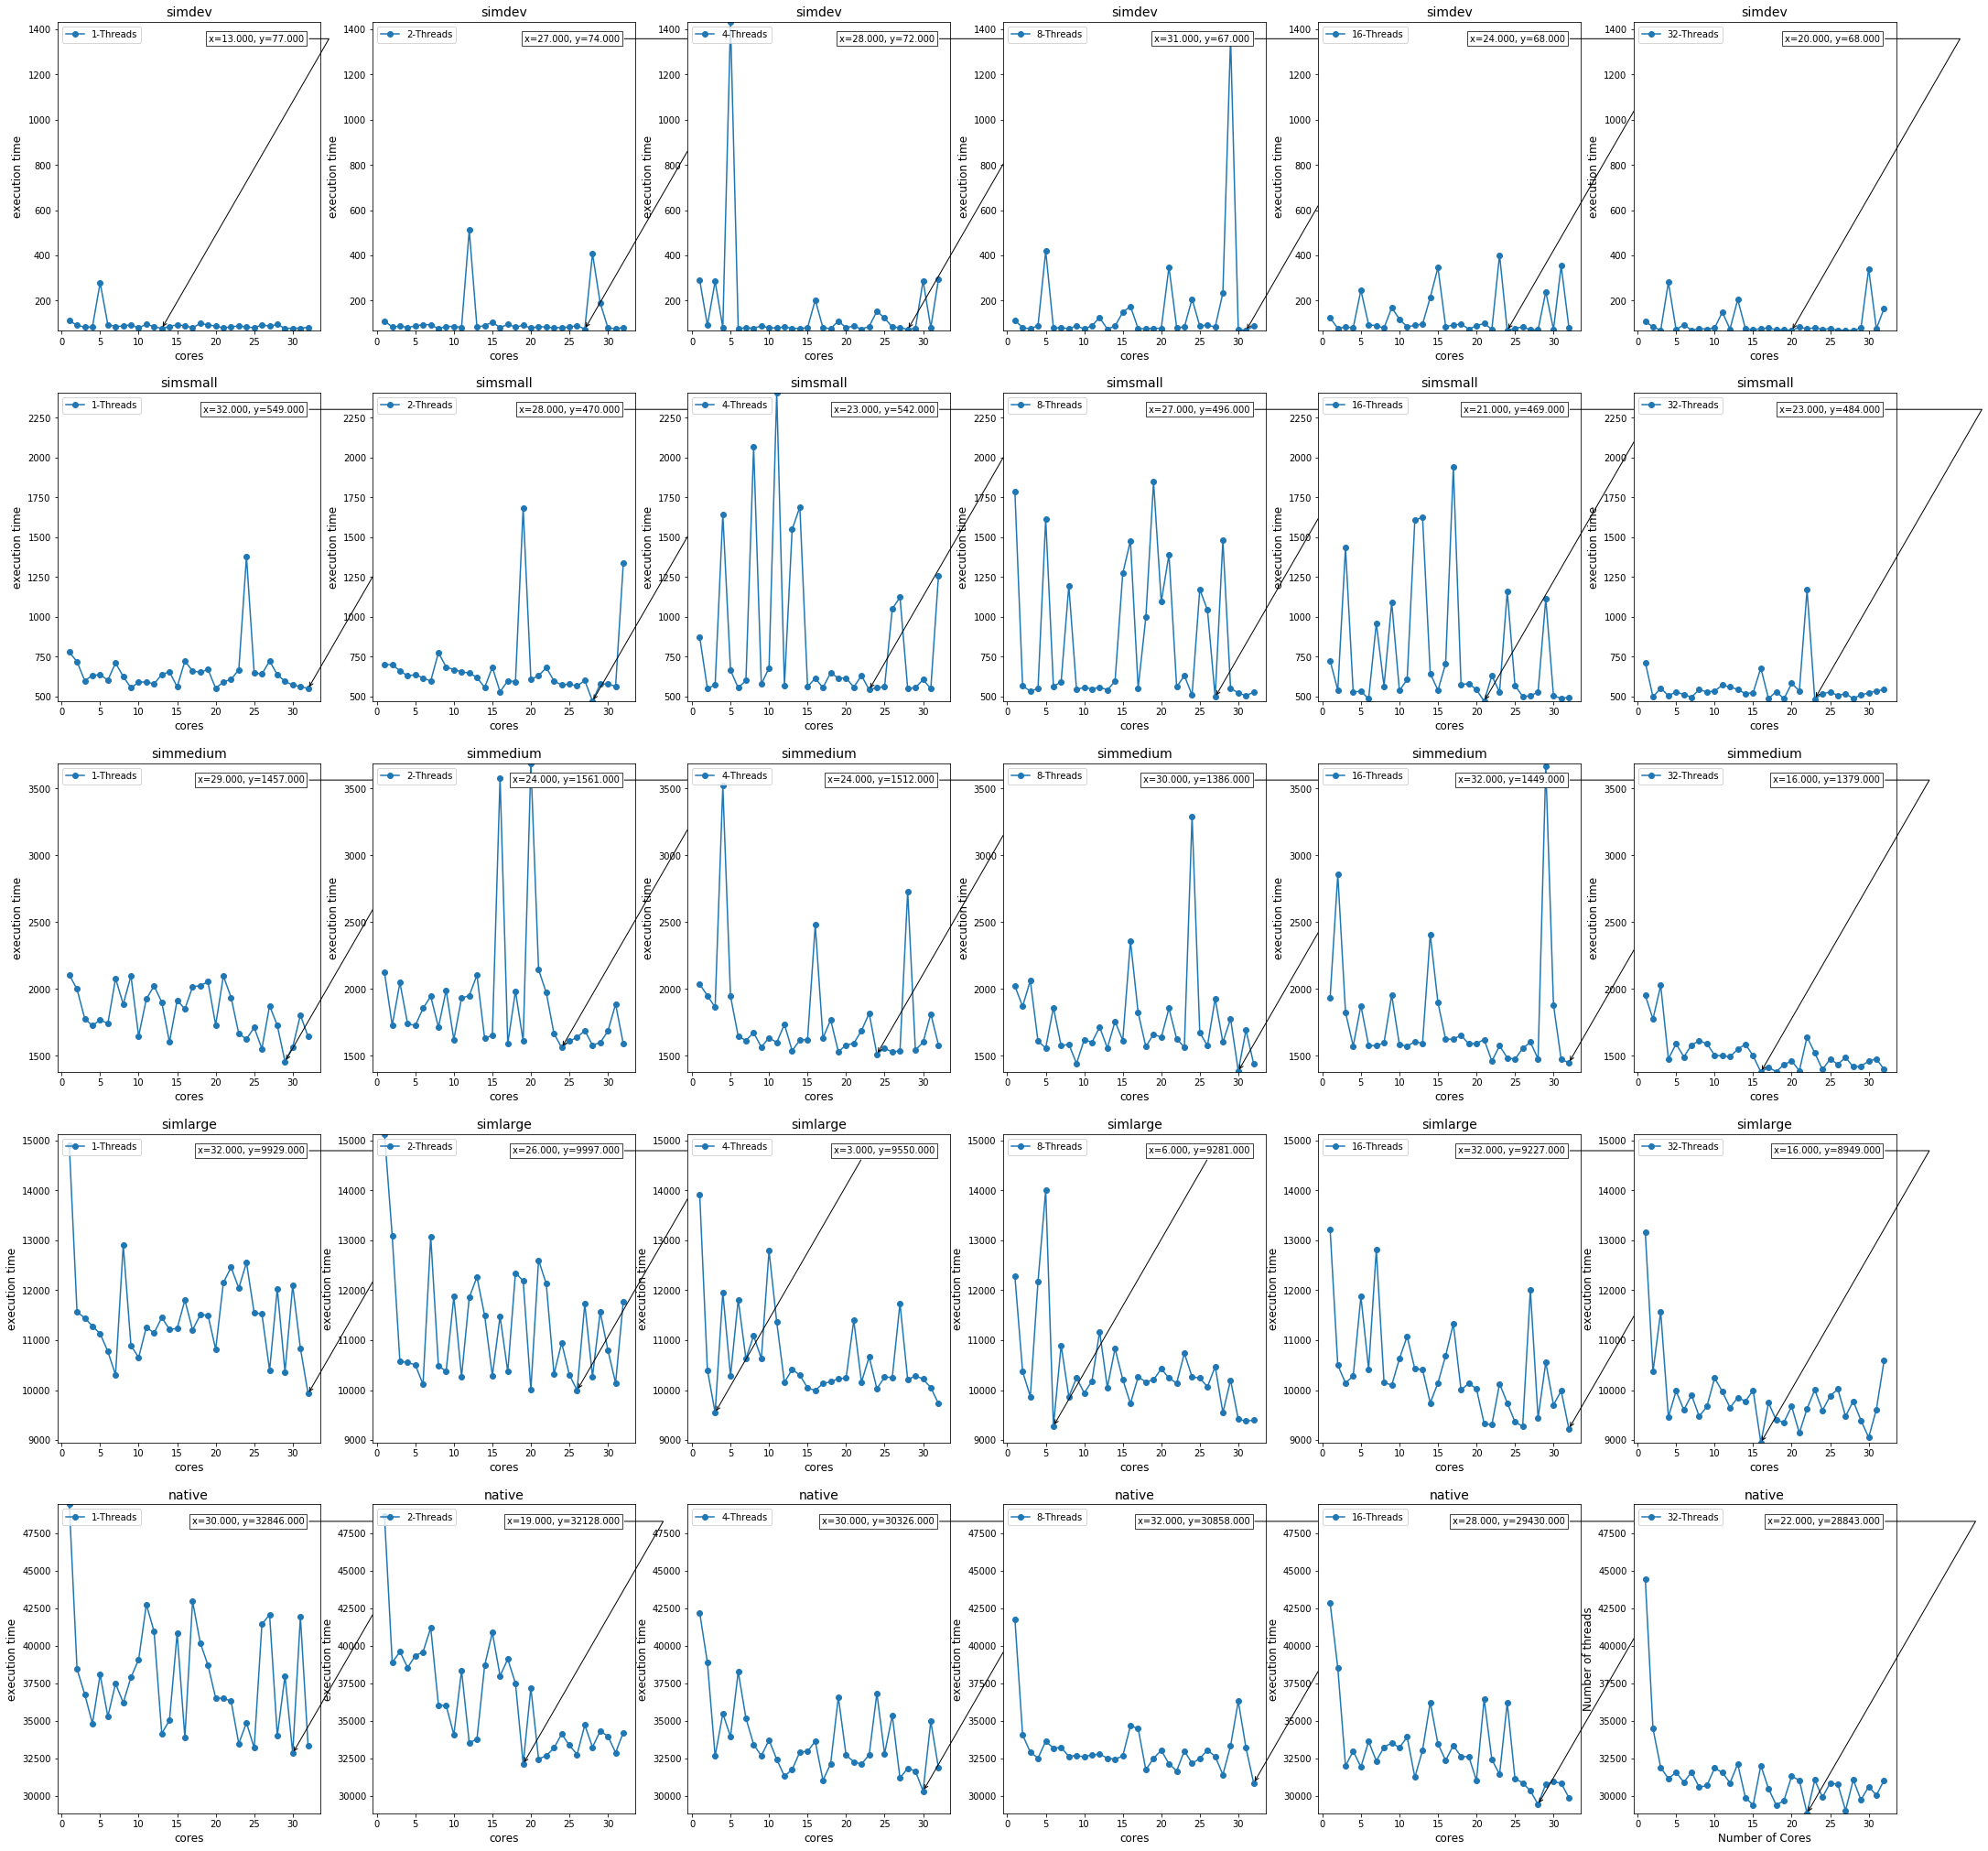

In [29]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,dedupData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

# x264 Analysis

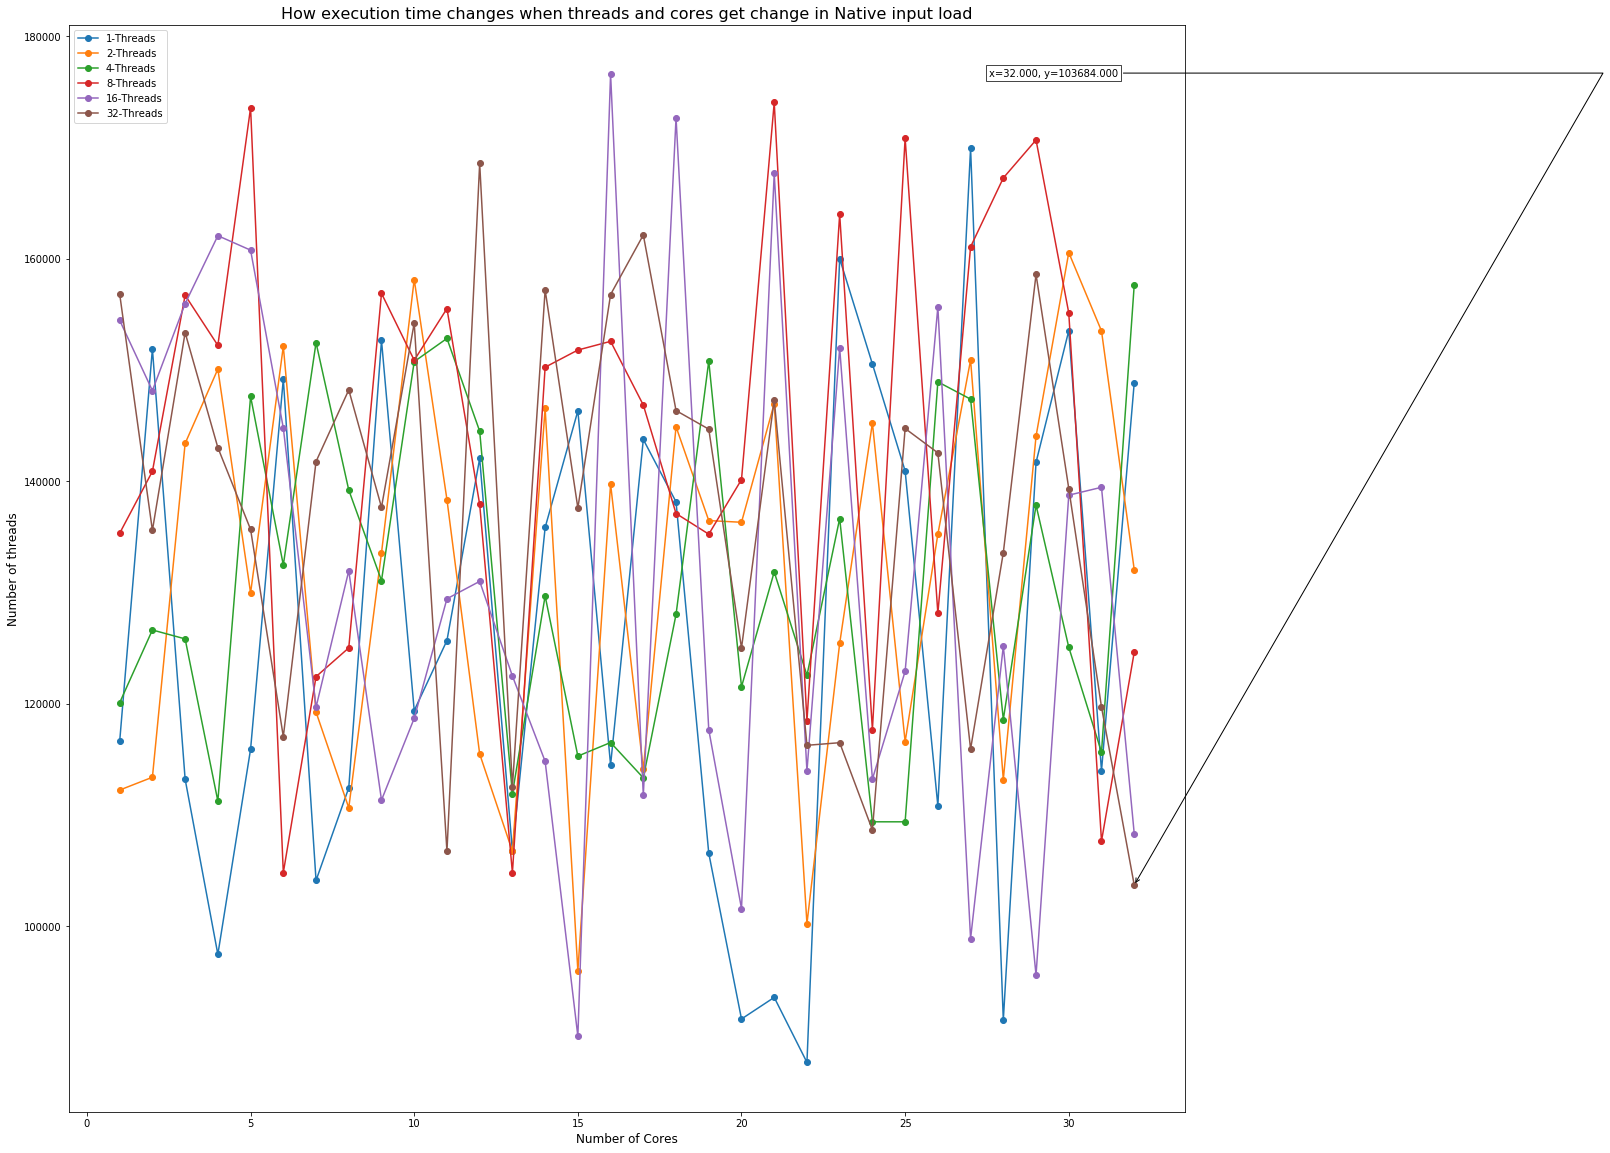

In [30]:
# Filtering for native
inputCombinationData = x264Data.loc[(x264Data['input'] == "native") ]
drawChartForInputs(coresCombinations,inputCombinationData,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change in Native input load",'Number of Cores',"Number of threads")

<Figure size 1440x1440 with 0 Axes>

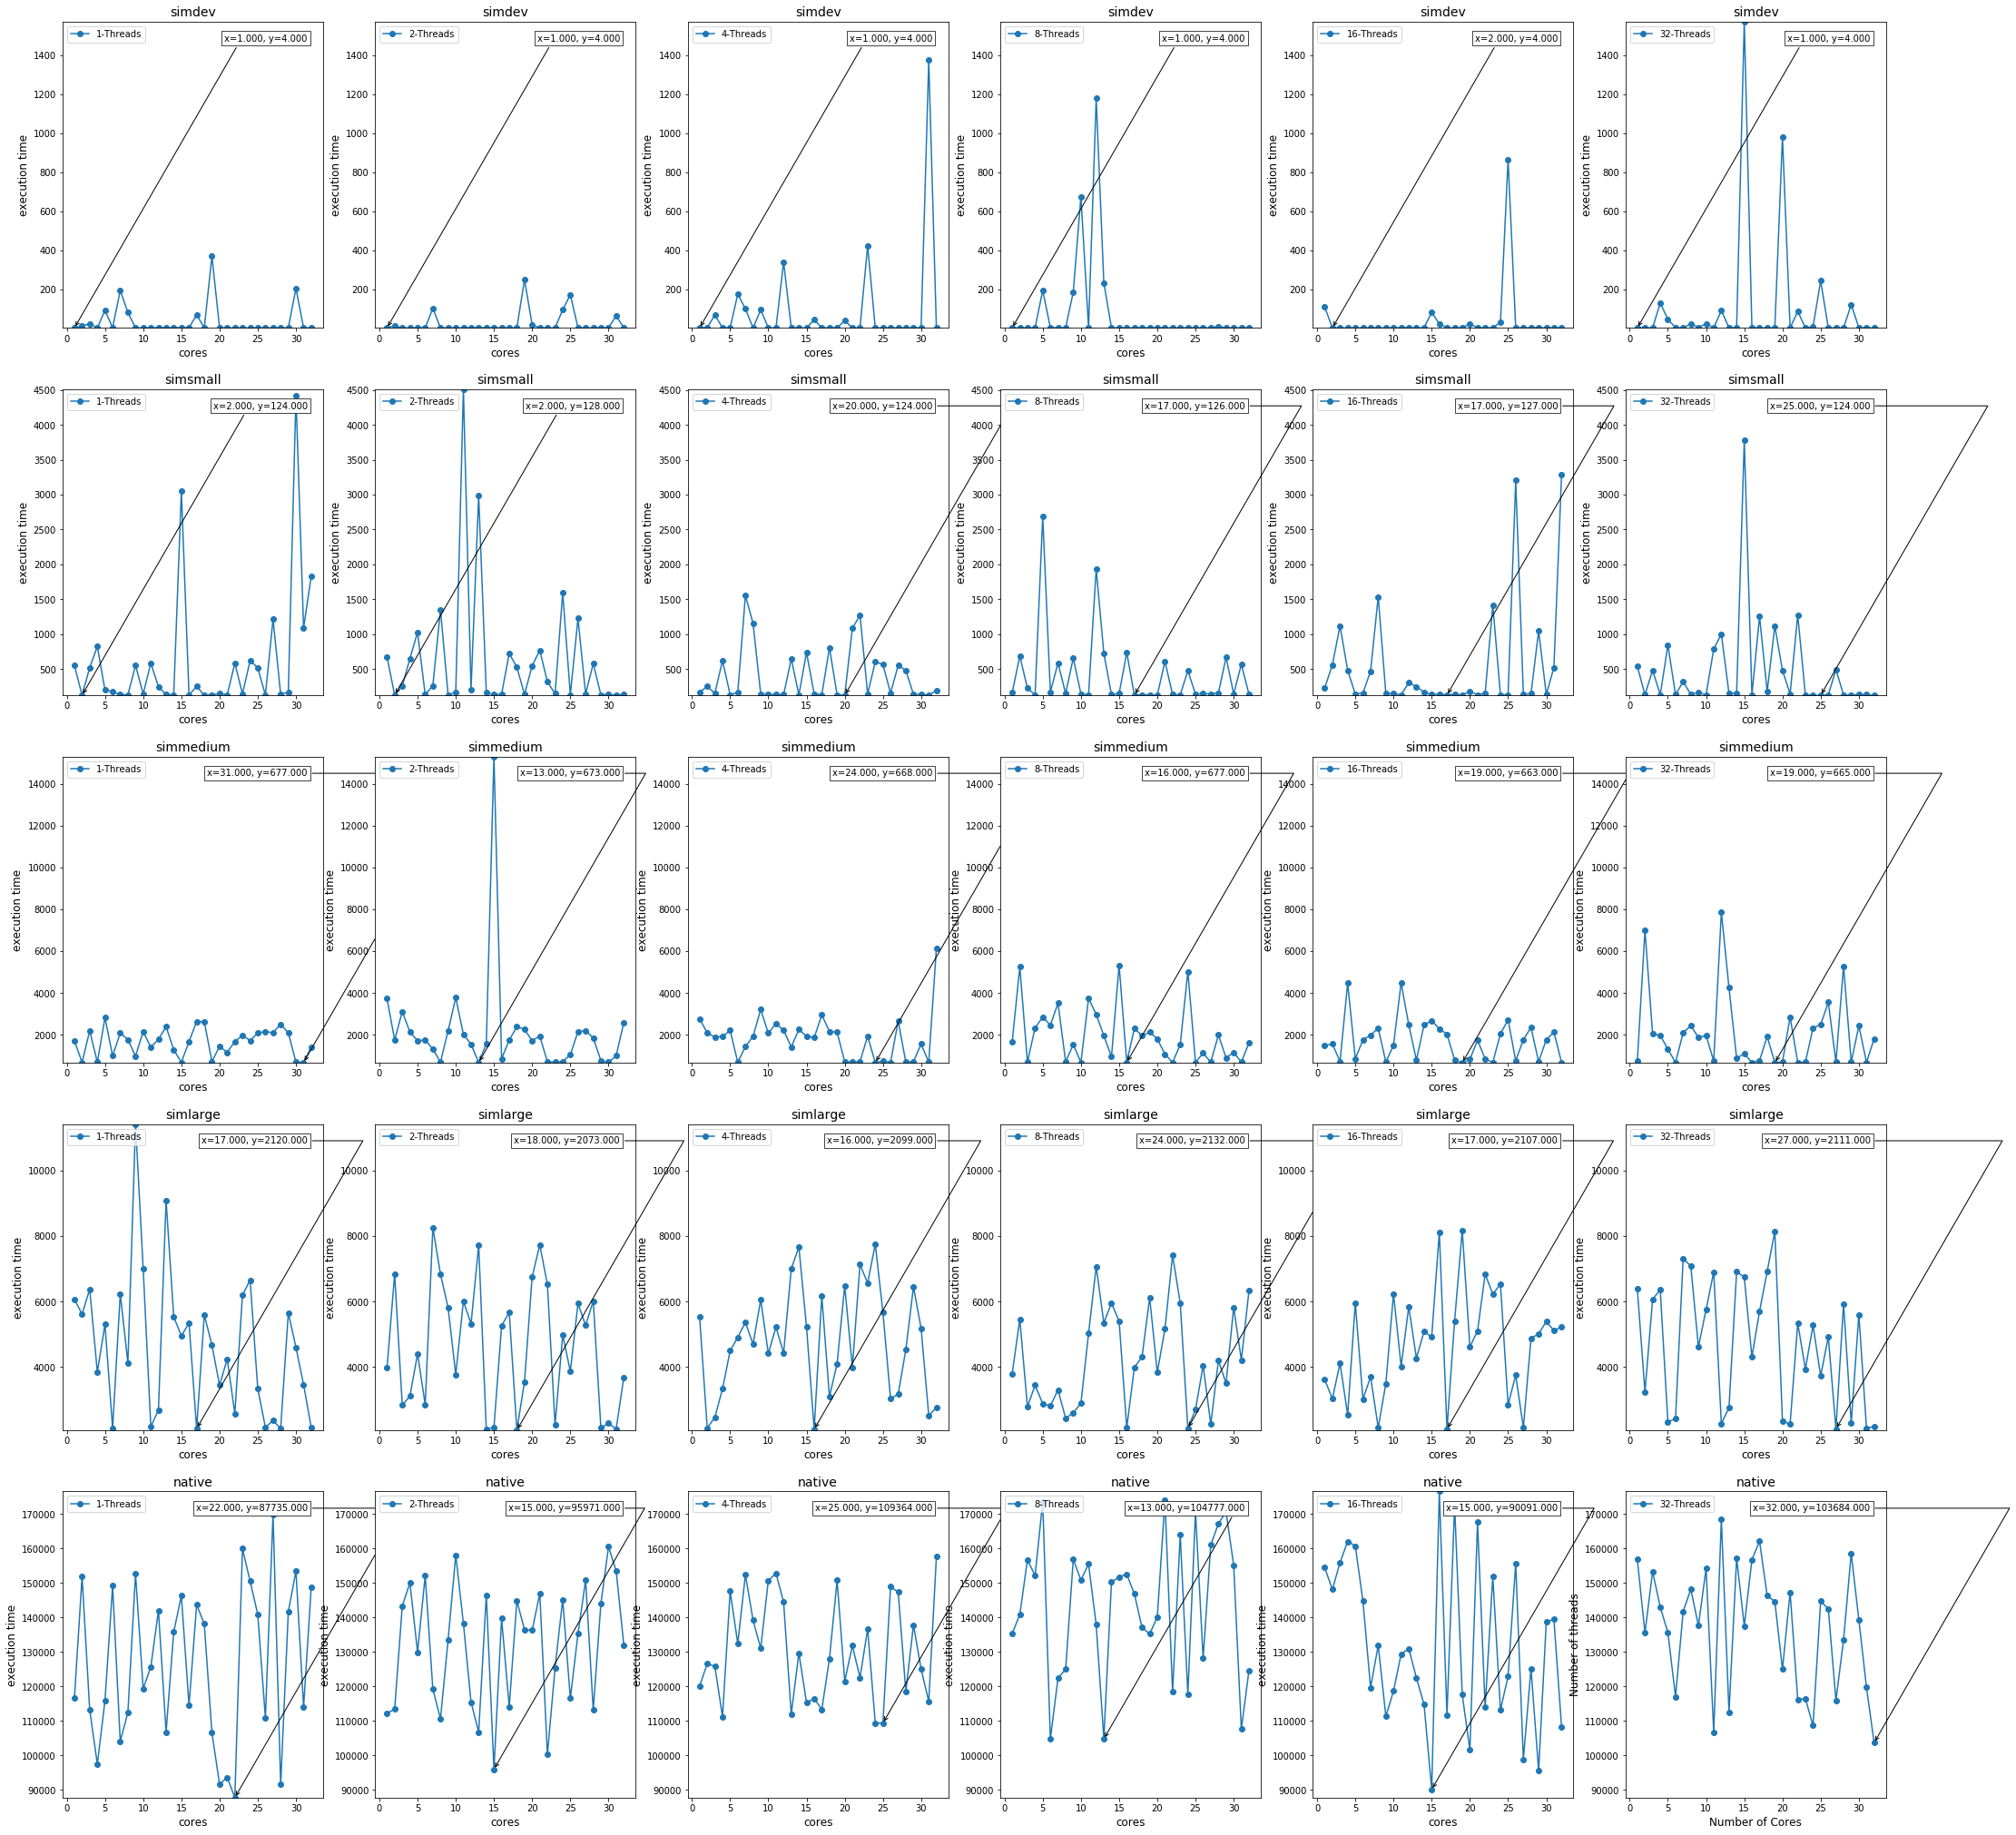

In [31]:
fig=plt.figure() #Creates a new figure
fig, axs = plt.subplots(5,6, figsize=(36, 36))
drawMatrixChartForInputs(coresCombinations,x264Data,axs,threadCombinations,'Threads',"How execution time changes when threads and cores get change",'Number of Cores',"Number of threads")

## Pair Plots for Dataset

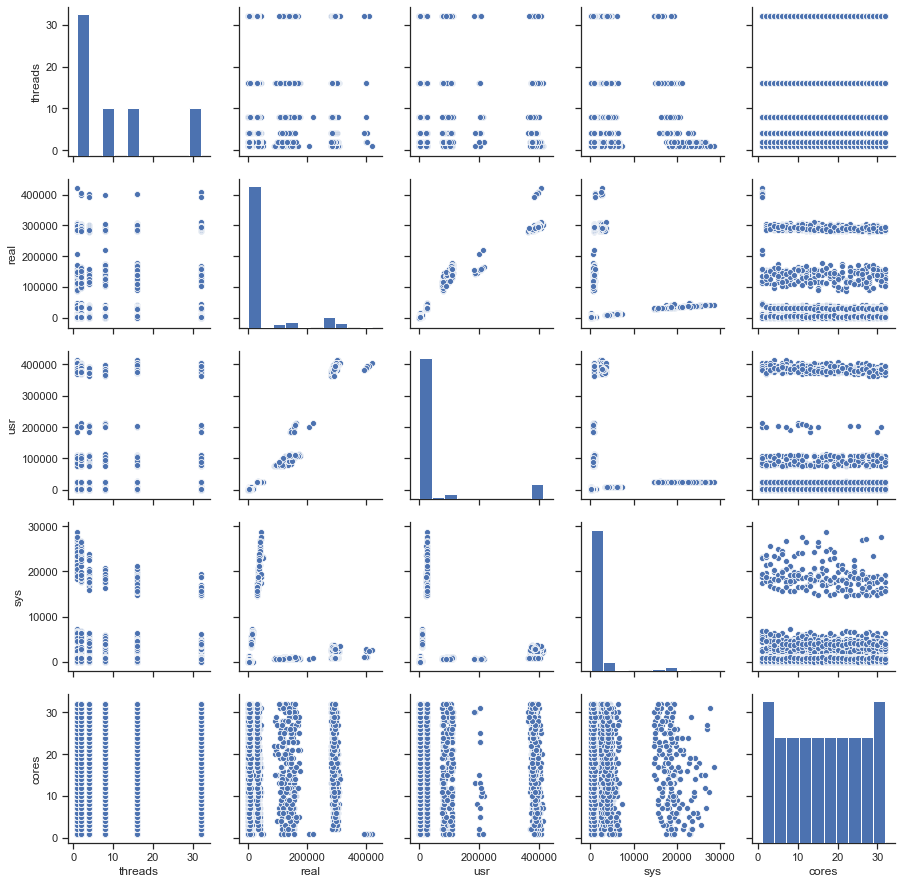

In [32]:
# Creating pair plot
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(parallelData)

# Machine Learning Models

## Data preprocessing

In [33]:
columns = ['name','input','compiler','threads','cores','real']
parallelData = parallelData[columns]
parallelData


name      input      compiler  threads  cores    real
5     ferret     simdev  gcc-pthreads        1      1      23
6     ferret   simsmall  gcc-pthreads        1      1     425
7     ferret  simmedium  gcc-pthreads        1      1    1337
8     ferret   simlarge  gcc-pthreads        1      1    6560
9     ferret     native  gcc-pthreads        1      1  420039
...      ...        ...           ...      ...    ...     ...
3850    x264     simdev  gcc-pthreads       32     32       4
3851    x264   simsmall  gcc-pthreads       32     32     124
3852    x264  simmedium  gcc-pthreads       32     32    1804
3853    x264   simlarge  gcc-pthreads       32     32    2188
3854    x264     native  gcc-pthreads       32     32  103684

[3840 rows x 6 columns]

### Transforming categorical columns using dummies

In [34]:
parallelData = pd.get_dummies(parallelData)
parallelData

threads  cores    real  name_dedup  name_ferret  name_x264  \
5           1      1      23           0            1          0   
6           1      1     425           0            1          0   
7           1      1    1337           0            1          0   
8           1      1    6560           0            1          0   
9           1      1  420039           0            1          0   
...       ...    ...     ...         ...          ...        ...   
3850       32     32       4           0            0          1   
3851       32     32     124           0            0          1   
3852       32     32    1804           0            0          1   
3853       32     32    2188           0            0          1   
3854       32     32  103684           0            0          1   

      input_native  input_simdev  input_simlarge  input_simmedium  \
5                0             1               0                0   
6                0             0               0                0   
7                0             0               0                1   
8                0             0               1                0   
9                1             0               0                0   
...            ...           ...             ...              ...   
3850             0             1               0                0   
3851             0             0               0                0   
3852             0             0               0                1   
3853             0             0               1                0   
3854             1             0               0                0   

      input_simsmall  compiler_gcc-pthreads  compiler_gcc-tbb  
5                  0                      1                 0  
6                  1                      1                 0  
7                  0                      1                 0  
8                  0                      1                 0  
9                  0                      1                 0  
...              ...                    ...               ...  
3850               0                      1                 0  
3851               1                      1                 0  
3852               0                      1                 0  
3853               0                      1                 0  
3854               0                      1                 0  

[3840 rows x 13 columns]

## ? Issue : Is it necessary to Scale y data and why two scalers

In [35]:
y_data = parallelData.iloc[:,2:3]
x_data = parallelData.drop(['real'],axis=1)
# Scaling the data set
# x_data_scaled = pd.DataFrame( StandardScaler().fit_transform(x_data),columns = x_data.columns)
# y_data_scaled = pd.DataFrame( StandardScaler().fit_transform(y_data),columns = y_data.columns)
x_data

threads  cores  name_dedup  name_ferret  name_x264  input_native  \
5           1      1           0            1          0             0   
6           1      1           0            1          0             0   
7           1      1           0            1          0             0   
8           1      1           0            1          0             0   
9           1      1           0            1          0             1   
...       ...    ...         ...          ...        ...           ...   
3850       32     32           0            0          1             0   
3851       32     32           0            0          1             0   
3852       32     32           0            0          1             0   
3853       32     32           0            0          1             0   
3854       32     32           0            0          1             1   

      input_simdev  input_simlarge  input_simmedium  input_simsmall  \
5                1               0                0               0   
6                0               0                0               1   
7                0               0                1               0   
8                0               1                0               0   
9                0               0                0               0   
...            ...             ...              ...             ...   
3850             1               0                0               0   
3851             0               0                0               1   
3852             0               0                1               0   
3853             0               1                0               0   
3854             0               0                0               0   

      compiler_gcc-pthreads  compiler_gcc-tbb  
5                         1                 0  
6                         1                 0  
7                         1                 0  
8                         1                 0  
9                         1                 0  
...                     ...               ...  
3850                      1                 0  
3851                      1                 0  
3852                      1                 0  
3853                      1                 0  
3854                      1                 0  

[3840 rows x 12 columns]

### Splitting the data

In [36]:

# Splitting the data set into training : 20% and testing : 80% beacuse the dataset has covered the all the combinational space
X_train,X_test,Y_train,Y_test = train_test_split(x_data,y_data,shuffle=True,train_size=0.2)

### XGBRegressor

In [68]:
#Creating a pipeline
XGBPipe = Pipeline([("scaler", StandardScaler()), ("xgb", XGBRegressor(nthread=-1) )])

# A parameter grid for XGBoost
params = {'xgb__min_child_weight':[4,5], 'xgb__gamma':[i/10.0 for i in range(3,6)],  'xgb__subsample':[i/10.0 for i in range(6,11)],
'xgb__colsample_bytree':[i/10.0 for i in range(6,11)], 'xgb__max_depth': [2,3,4]}

grid = GridSearchCV(pipe, params,cv=5)
grid.fit(X_train, Y_train)


[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:55:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                          

In [60]:
bestParams  = grid.best_params_
print('Best Params : ',grid.best_params_)
print('Best Params : ',grid.best_score_)

# Print the r2 score
print(r2_score(Y_test, grid.best_estimator_.predict(X_test)))



Best Params :  {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__min_child_weight': 5, 'xgb__subsample': 0.9}
Best Params :  0.9847635318516573
0.9806886589671249


In [61]:
xgb_best = XGBRegressor(**grid.best_params_)
xgb_best.fit(X_train,Y_train)

print(r2_score(Y_test, xgb_best.predict(X_test)))

[22:49:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9827047792462607


### Random Forrest

In [65]:
randomForrestPipe =  Pipeline([("scaler", StandardScaler()), ("rfr", RandomForestRegressor() )])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'rfr__n_estimators': n_estimators,
               'rfr__max_features': max_features,
               'rfr__max_depth': max_depth,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf,
               'rfr__bootstrap': bootstrap}



In [70]:
rf_random = RandomizedSearchCV(randomForrestPipe, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished
D:\Anaconda\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


{'rfr__n_estimators': 1000,
 'rfr__min_samples_split': 5,
 'rfr__min_samples_leaf': 4,
 'rfr__max_features': 'auto',
 'rfr__max_depth': 100,
 'rfr__bootstrap': True}

In [71]:
rf_random.best_score_

0.9832815842009297